In [1605]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn.model_selection as model_selection

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import tree, ensemble, neural_network, linear_model
from sklearn import metrics

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve

from pandas import get_dummies



In [1606]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

#### if-setninger for å sjekke ulike metoder om det har innvirkning

In [1607]:
#Optimalisering
behold_sykdomskategori=False

#Variabelutvinning
merge_overlevelsesestimater=False
merge_cancer=True
nyre_diabetes_merge=False
merge_diabetes_alder=False

if_clip_5=True
merge_fysiologisk_komorbiditeter=False
sykdomkategori_gjennomsnitt=False

#NaN verdier
fill_in_mean=False
fill_in_knn=True
run_grid_search_forAll=False
cross_validation=False


#ulike modeller
gradientBoosting_first=False
mlp_first=False
extraTrees_first=False
RandomTree_log=False

extraTrees_second=True
gradientBoosting_second=True

## 1.1 Leser inn filer

In [1608]:
df_hospital=pd.read_csv('raw_data/hospital.csv')

In [1609]:
df_demographic=pd.read_csv('raw_data/demographic.csv')

In [1610]:
df_physiological=pd.read_table('raw_data/physiological.txt')

In [1611]:
json_df=pd.read_json('raw_data/severity.json')
df_severity = json_df.iloc[:, 0:-1].explode(list(json_df.columns[2:-1])) 
df_severity.reset_index(drop=True, inplace=True)

#### 1.2 Slår sammen tabellene, fjerner duplikater og setter pasient_id som index. 

In [1612]:
df=df_demographic.merge(df_hospital,on='pasient_id',how='outer')\
    .merge(df_physiological,on='pasient_id',how='outer')\
    .merge(df_severity,on='pasient_id',how='outer')

#### Vil ikke ha duplikater i df, så fjerner. 

In [1613]:
df=df.drop_duplicates(subset=['pasient_id']).reset_index(drop=True)

In [1614]:
df.set_index('pasient_id', inplace=True)


#### 1.3 Deler inn i train/validering/test

In [1615]:
X = df.drop('oppholdslengde', axis=1)
y = df['oppholdslengde']

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)


## 2.1 Optimaliserer dataen

#### 2.1.1 Fjerner der oppholdslengden er negativ, og støy. 

In [1616]:
train_df = train_df.loc[train_df['oppholdslengde'] >= 0].reset_index(drop=True)
val_df = val_df.loc[val_df['oppholdslengde'] >= 0].reset_index(drop=True)
test_df = test_df.loc[test_df['oppholdslengde'] >= 0].reset_index(drop=True)
train_df


,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori_id,sykdomskategori,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,oppholdslengde
0,86.13599,male,12.0,NaN,white,0,60.0,7.899414,130.0,26.0,38.00000,353.31250,NaN,NaN,6.199219,134.0,7.389648,80.0,43.0,0.0,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,1,0.0,0.0,0.0,40.796875,54.0,0.282959,0.173981,0,0,no,0.4,0.3,None,26
1,70.09698,male,9.0,under $11k,white,0,73.0,10.599609,65.0,7.0,36.50000,182.50000,NaN,NaN,1.399902,138.0,7.489258,94.0,19.0,2010.0,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,0,0.0,6.0,0.0,17.597656,17.0,0.858887,0.809937,0,0,no,0.9,0.9,None,13
2,69.15295,male,NaN,NaN,white,0,102.0,11.000000,66.0,24.0,35.69531,224.00000,3.899902,0.899902,1.199951,131.0,7.239258,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,0,COPD,3,0.0,None,None,18.0,29.0,0.843994,0.743896,0,0,no,0.8,0.6,None,8
3,89.88397,male,8.0,under $11k,white,0,61.0,NaN,96.0,20.0,36.39844,NaN,NaN,NaN,NaN,140.0,NaN,NaN,NaN,2800.0,BrY,COPD/CHF/Cirrhosis,1,CHF,2,0.0,None,1.0,21.0,40.0,0.756958,0.61499,0,0,no,0.95,0.6,dnr ved innleggelse,5
4,76.06598,female,8.0,NaN,white,0,114.0,12.298828,75.0,32.0,39.09375,151.40625,4.599609,0.500000,0.799927,131.0,7.339844,NaN,NaN,NaN,DWw,Coma,0,Coma,0,61.0,None,0.0,23.296875,41.0,0.312988,0.240997,0,0,no,0.3,0.2,dnr ved innleggelse,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410,38.51297,male,12.0,$11-$25k,black,0,83.0,11.199219,78.0,28.0,35.39844,NaN,3.099609,0.799927,1.099854,134.0,NaN,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,1,CHF,3,0.0,0.0,0.0,24.097656,18.0,0.890991,0.817993,0,0,no,1.0,0.95,None,5
5411,73.81000,male,6.0,under $11k,white,0,103.0,7.599609,189.0,30.0,36.19531,222.21875,3.099609,0.299988,0.799927,137.0,7.479492,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,1,COPD,2,0.0,1.0,None,25.0,39.0,0.684937,0.517944,0,0,yes,0.9,0.6,dnr ved innleggelse,5
5412,38.94299,male,14.0,>$50k,white,0,108.0,17.699219,115.0,28.0,36.00000,304.00000,1.899902,8.898438,1.199951,135.0,7.399414,330.0,22.0,1360.0,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,0,0.0,None,5.0,30.0,62.0,0.744995,0.665894,0,0,no,0.9,0.9,None,12
5413,58.44800,female,12.0,NaN,white,1,71.0,24.296875,119.0,32.0,36.79688,171.40625,2.399902,6.599609,1.199951,136.0,7.349609,313.0,40.0,1805.0,ChE,Cancer,1,Lung Cancer,1,0.0,5.0,4.0,16.898438,8.0,0.725952,0.451965,0,0,metastatic,0.7,0.6,None,16


In [1617]:
train_df.drop(columns=['sykehusdød'], inplace=True)
val_df.drop(columns=['sykehusdød'], inplace=True)
test_df.drop(columns=['sykehusdød'], inplace=True)

train_df.drop(columns=['dødsfall'], inplace=True)
val_df.drop(columns=['dødsfall'], inplace=True)
test_df.drop(columns=['dødsfall'], inplace=True)

In [1618]:
train_df.drop(columns=['adl_pasient'], inplace=True)
val_df.drop(columns=['adl_pasient'], inplace=True)
test_df.drop(columns=['adl_pasient'], inplace=True)

train_df.drop(columns=['bilirubin'], inplace=True)
val_df.drop(columns=['bilirubin'], inplace=True)
test_df.drop(columns=['bilirubin'], inplace=True)

In [1619]:
train_df.drop(columns=['dnr_status'], inplace=True)
val_df.drop(columns=['dnr_status'], inplace=True)
test_df.drop(columns=['dnr_status'], inplace=True)

##### 2.1.2 Setter eventuelle negative verdier for alder til NaN.

In [1620]:
train_df['alder'] = df_demographic['alder'].apply(lambda x: x if x > 0 else np.nan)
val_df['alder'] = df_demographic['alder'].apply(lambda x: x if x > 0 else np.nan)
test_df['alder'] = df_demographic['alder'].apply(lambda x: x if x > 0 else np.nan)
train_df

,alder,kjønn,utdanning,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,sykdomskategori_id,sykdomskategori,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,oppholdslengde
0,60.33899,male,12.0,NaN,white,60.0,7.899414,130.0,26.0,38.00000,353.31250,NaN,6.199219,134.0,7.389648,80.0,43.0,0.0,A1s,ARF/MOSF,ARF/MOSF w/Sepsis,1,0.0,0.0,40.796875,54.0,0.282959,0.173981,0,0,no,0.4,0.3,26
1,52.74698,male,9.0,under $11k,white,73.0,10.599609,65.0,7.0,36.50000,182.50000,NaN,1.399902,138.0,7.489258,94.0,19.0,2010.0,A1s,ARF/MOSF,ARF/MOSF w/Sepsis,0,0.0,0.0,17.597656,17.0,0.858887,0.809937,0,0,no,0.9,0.9,13
2,42.38498,male,NaN,NaN,white,102.0,11.000000,66.0,24.0,35.69531,224.00000,3.899902,1.199951,131.0,7.239258,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,COPD,3,0.0,None,18.0,29.0,0.843994,0.743896,0,0,no,0.8,0.6,8
3,79.88495,male,8.0,under $11k,white,61.0,NaN,96.0,20.0,36.39844,NaN,NaN,NaN,140.0,NaN,NaN,NaN,2800.0,BrY,COPD/CHF/Cirrhosis,CHF,2,0.0,1.0,21.0,40.0,0.756958,0.61499,0,0,no,0.95,0.6,5
4,93.01599,female,8.0,NaN,white,114.0,12.298828,75.0,32.0,39.09375,151.40625,4.599609,0.799927,131.0,7.339844,NaN,NaN,NaN,DWw,Coma,Coma,0,61.0,0.0,23.296875,41.0,0.312988,0.240997,0,0,no,0.3,0.2,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410,46.97598,male,12.0,$11-$25k,black,83.0,11.199219,78.0,28.0,35.39844,NaN,3.099609,1.099854,134.0,NaN,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,CHF,3,0.0,0.0,24.097656,18.0,0.890991,0.817993,0,0,no,1.0,0.95,5
5411,49.48099,male,6.0,under $11k,white,103.0,7.599609,189.0,30.0,36.19531,222.21875,3.099609,0.799927,137.0,7.479492,NaN,NaN,NaN,BrY,COPD/CHF/Cirrhosis,COPD,2,0.0,None,25.0,39.0,0.684937,0.517944,0,0,yes,0.9,0.6,5
5412,82.20898,male,14.0,>$50k,white,108.0,17.699219,115.0,28.0,36.00000,304.00000,1.899902,1.199951,135.0,7.399414,330.0,22.0,1360.0,A1s,ARF/MOSF,ARF/MOSF w/Sepsis,0,0.0,5.0,30.0,62.0,0.744995,0.665894,0,0,no,0.9,0.9,12
5413,77.46997,female,12.0,NaN,white,71.0,24.296875,119.0,32.0,36.79688,171.40625,2.399902,1.199951,136.0,7.349609,313.0,40.0,1805.0,ChE,Cancer,Lung Cancer,1,0.0,4.0,16.898438,8.0,0.725952,0.451965,0,0,metastatic,0.7,0.6,16


#### 2.1.3 Gjør om kategorisk til numerisk, og mapper for de verdiene jeg ser er hensiktsmessig nå. 

In [1621]:
train_df.isnull().sum()

alder                               5
kjønn                               0
utdanning                         983
inntekt                          1763
etnisitet                          28
blodtrykk                           0
hvite_blodlegemer                 118
hjertefrekvens                      0
respirasjonsfrekvens                0
kroppstemperatur                    0
lungefunksjon                    1351
serumalbumin                     1976
kreatinin                          35
natrium                             0
blod_ph                          1328
glukose                          2680
blodurea_nitrogen                2588
urinmengde                       2871
sykdomskategori_id                  0
sykdomskategori                     0
sykdom_underkategori                0
antall_komorbiditeter               0
koma_score                          0
adl_stedfortreder                1702
fysiologisk_score                   0
apache_fysiologisk_score            0
overlevelses

##### Kjønn/etnisitet, ser det kun er 28 som mangler etnisitet så setter dem til den mest hyppigste.  

In [1622]:
most_frequent_etnisitet = train_df['etnisitet'].mode()[0]  # Henter den mest hyppige verdien

train_df['etnisitet'] = train_df['etnisitet'].fillna(most_frequent_etnisitet)
val_df['etnisitet'] = val_df['etnisitet'].fillna(most_frequent_etnisitet)
test_df['etnisitet'] = test_df['etnisitet'].fillna(most_frequent_etnisitet)

etnisitet_mapping = {
    'white': 0,
    'black': 1,
    'asian': 2,
    'hispanic': 3,
    'other': 4,
}

train_df['etnisitet'] = train_df['etnisitet'].map(etnisitet_mapping)
val_df['etnisitet'] = val_df['etnisitet'].map(etnisitet_mapping)
test_df['etnisitet'] = test_df['etnisitet'].map(etnisitet_mapping)


In [1623]:
train_df=get_dummies(train_df, columns=['kjønn'])
train_df['kjønn'] = train_df['kjønn_male'].astype(int)  
train_df.drop(columns=['kjønn_female', 'kjønn_male'], inplace=True) 

val_df=get_dummies(val_df, columns=['kjønn'])
val_df['kjønn'] = val_df['kjønn_male'].astype(int)  
val_df.drop(columns=['kjønn_female', 'kjønn_male'], inplace=True) 

test_df=get_dummies(test_df, columns=['kjønn'])
test_df['kjønn'] = test_df['kjønn_male'].astype(int)  
test_df.drop(columns=['kjønn_female', 'kjønn_male'], inplace=True) 

##### Sykdom underkategori og kreft til numeriske verdier ved OneHotEncoder, og optimalisering av sykdom kategori. 


In [1624]:
alle_like = (train_df['sykdomskategori'] == train_df['sykdom_underkategori']).all()

if alle_like:
    print("Alle verdier i kolonnene er like.")
else:
    print("Det finnes forskjeller mellom kolonnene.")


Det finnes forskjeller mellom kolonnene.


In [1625]:
columns_to_encode = ['kreft', 'sykdom_underkategori'] 
encoder = OneHotEncoder(drop=None, sparse_output=False)
encoded_columns = encoder.fit_transform(train_df[columns_to_encode])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
train_df = pd.concat([train_df.drop(columns=columns_to_encode), encoded_df], axis=1)

val_encoded_columns = encoder.transform(val_df[columns_to_encode])
val_encoded_df = pd.DataFrame(val_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
val_df = pd.concat([val_df.drop(columns=columns_to_encode), val_encoded_df], axis=1)

test_encoded_columns = encoder.transform(test_df[columns_to_encode])
test_encoded_df = pd.DataFrame(test_encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
test_df = pd.concat([test_df.drop(columns=columns_to_encode), test_encoded_df], axis=1)

##### Ser jeg kan redusere antall kolonner for kreft, kreft: ja=1, nei=0, metastatic: ja=1, nei=0

In [1626]:
train_df['kreft'] = ((train_df['kreft_yes'] == 1) | (train_df['kreft_metastatic'] == 1)).astype(int)
train_df.drop(columns=['kreft_yes', 'kreft_no'], inplace=True)

val_df['kreft'] = ((val_df['kreft_yes'] == 1) | (val_df['kreft_metastatic'] == 1)).astype(int)
val_df.drop(columns=['kreft_yes', 'kreft_no'], inplace=True)

test_df['kreft'] = ((test_df['kreft_yes'] == 1) | (test_df['kreft_metastatic'] == 1)).astype(int)
test_df.drop(columns=['kreft_yes', 'kreft_no'], inplace=True)


##### Mapper om sykdomskategori-id, forteller om en person har flere sykdommer og hvilke, også forteller underkategoriene hvilke som er mest vektlagt. 

In [1627]:
train_df['sykdomskategori']

0                 ARF/MOSF
1                 ARF/MOSF
2       COPD/CHF/Cirrhosis
3       COPD/CHF/Cirrhosis
4                     Coma
               ...        
5410    COPD/CHF/Cirrhosis
5411    COPD/CHF/Cirrhosis
5412              ARF/MOSF
5413                Cancer
5414                Cancer
Name: sykdomskategori, Length: 5415, dtype: object

In [1628]:
if behold_sykdomskategori: 
    sykdomskategori_mapping = {
            'ARF/MOSF': 1,
            'COPD/CHF/Cirrhosis': 2,
            'Coma': 3,
            'Cancer': 4,
    }
    train_df['sykdomskategori'] = train_df['sykdomskategori'].map(sykdomskategori_mapping)
    val_df['sykdomskategori'] = val_df['sykdomskategori'].map(sykdomskategori_mapping)
    test_df['sykdomskategori'] = test_df['sykdomskategori'].map(sykdomskategori_mapping)
else:
    train_df.drop(columns=['sykdomskategori'], inplace=True)
    val_df.drop(columns=['sykdomskategori'], inplace=True)
    test_df.drop(columns=['sykdomskategori'], inplace=True)

##### Ser at det er unødvendig med sykdomskategori_id, så dropper.

In [1629]:
train_df.drop(columns=['sykdomskategori_id'], inplace=True)
val_df.drop(columns=['sykdomskategori_id'], inplace=True)
test_df.drop(columns=['sykdomskategori_id'], inplace=True)

##### Inntekt og utdanning

In [1630]:
income_mapping= {
    'under $11k': 0,
    '$11-$25k': 1,
    '$25-$50k': 2,
    '>$50k': 3,
}

train_df['inntekt'] = train_df['inntekt'].map(income_mapping)
val_df['inntekt'] = val_df['inntekt'].map(income_mapping)
test_df['inntekt'] = test_df['inntekt'].map(income_mapping)
train_df.head(n=20)

,alder,utdanning,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,oppholdslengde,kjønn,kreft_metastatic,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,kreft
0,60.33899,12.0,NaN,0,60.0,7.899414,130.0,26.0,38.00000,353.31250,NaN,6.199219,134.0,7.389648,80.0,43.0,0.0,1,0.0,0.0,40.796875,54.0,0.282959,0.173981,0,0,0.4,0.3,26,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,52.74698,9.0,0.0,0,73.0,10.599609,65.0,7.0,36.50000,182.50000,NaN,1.399902,138.0,7.489258,94.0,19.0,2010.0,0,0.0,0.0,17.597656,17.0,0.858887,0.809937,0,0,0.9,0.9,13,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,42.38498,NaN,NaN,0,102.0,11.000000,66.0,24.0,35.69531,224.00000,3.899902,1.199951,131.0,7.239258,NaN,NaN,NaN,3,0.0,None,18.0,29.0,0.843994,0.743896,0,0,0.8,0.6,8,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,79.88495,8.0,0.0,0,61.0,NaN,96.0,20.0,36.39844,NaN,NaN,NaN,140.0,NaN,NaN,NaN,2800.0,2,0.0,1.0,21.0,40.0,0.756958,0.61499,0,0,0.95,0.6,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,93.01599,8.0,NaN,0,114.0,12.298828,75.0,32.0,39.09375,151.40625,4.599609,0.799927,131.0,7.339844,NaN,NaN,NaN,0,61.0,0.0,23.296875,41.0,0.312988,0.240997,0,0,0.3,0.2,25,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
5,62.37097,NaN,NaN,0,105.0,6.500000,99.0,28.0,35.69531,210.00000,NaN,1.899902,126.0,7.239258,115.0,38.0,1893.0,5,61.0,None,23.199219,45.0,0.437988,0.237,1,0,None,None,4,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
6,86.83899,14.0,1.0,0,60.0,22.500000,136.0,9.0,35.89844,202.50000,2.399902,2.000000,152.0,7.409180,NaN,NaN,NaN,2,9.0,0.0,33.898438,61.0,0.40094,0.281982,1,0,None,None,23,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,85.65594,8.0,NaN,0,112.0,3.799805,80.0,16.0,38.09375,314.25000,3.000000,1.599854,142.0,7.229492,145.0,27.0,3050.0,0,0.0,0.0,27.898438,48.0,0.754883,0.67688,0,0,0.98,0.95,10,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,42.25897,8.0,1.0,0,83.0,15.898438,85.0,20.0,36.00000,462.50000,NaN,1.299805,136.0,7.349609,NaN,NaN,NaN,2,0.0,None,17.296875,16.0,0.845947,0.747925,0,0,0.95,0.8,6,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,47.94498,13.0,3.0,0,110.0,0.199982,120.0,42.0,38.50000,248.00000,NaN,2.899902,140.0,7.359375,NaN,NaN,NaN,1,44.0,0.0,41.398438,87.0,0.028999,0.007,0,0,None,None,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [1631]:
bins = [0, 9, 12, 16, float('inf')]  # Grunnskole, videregående, høyere utdanning, postgraduate
labels = ['grunnskole', 'videregående', 'høyere utdanning', 'postgraduate']

# Bruk pd.cut for å plassere utdanningsår i kategorier
train_df['utdanning_kategori'] = pd.cut(train_df['utdanning'], bins=bins, labels=labels, include_lowest=True)
val_df['utdanning_kategori'] = pd.cut(val_df['utdanning'], bins=bins, labels=labels, include_lowest=True)
test_df['utdanning_kategori'] = pd.cut(test_df['utdanning'], bins=bins, labels=labels, include_lowest=True)

utdanning_mapping = {
    'grunnskole': 0,
    'videregående': 1,
    'høyere utdanning': 2,
    'postgraduate': 3,
}

train_df['utdanning_kategori'] = train_df['utdanning_kategori'].map(utdanning_mapping)
val_df['utdanning_kategori'] = val_df['utdanning_kategori'].map(utdanning_mapping)
test_df['utdanning_kategori'] = test_df['utdanning_kategori'].map(utdanning_mapping)

train_df.drop(columns=['utdanning'], inplace=True)
val_df.drop(columns=['utdanning'], inplace=True)
test_df.drop(columns=['utdanning'], inplace=True)

In [1632]:
train_df

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,oppholdslengde,kjønn,kreft_metastatic,sykdom_underkategori_ARF/MOSF w/Sepsis,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig,kreft,utdanning_kategori
0,60.33899,NaN,0,60.0,7.899414,130.0,26.0,38.00000,353.31250,NaN,6.199219,134.0,7.389648,80.0,43.0,0.0,1,0.0,0.0,40.796875,54.0,0.282959,0.173981,0,0,0.4,0.3,26,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,52.74698,0.0,0,73.0,10.599609,65.0,7.0,36.50000,182.50000,NaN,1.399902,138.0,7.489258,94.0,19.0,2010.0,0,0.0,0.0,17.597656,17.0,0.858887,0.809937,0,0,0.9,0.9,13,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,42.38498,NaN,0,102.0,11.000000,66.0,24.0,35.69531,224.00000,3.899902,1.199951,131.0,7.239258,NaN,NaN,NaN,3,0.0,None,18.0,29.0,0.843994,0.743896,0,0,0.8,0.6,8,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,NaN
3,79.88495,0.0,0,61.0,NaN,96.0,20.0,36.39844,NaN,NaN,NaN,140.0,NaN,NaN,NaN,2800.0,2,0.0,1.0,21.0,40.0,0.756958,0.61499,0,0,0.95,0.6,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,93.01599,NaN,0,114.0,12.298828,75.0,32.0,39.09375,151.40625,4.599609,0.799927,131.0,7.339844,NaN,NaN,NaN,0,61.0,0.0,23.296875,41.0,0.312988,0.240997,0,0,0.3,0.2,25,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410,46.97598,1.0,1,83.0,11.199219,78.0,28.0,35.39844,NaN,3.099609,1.099854,134.0,NaN,NaN,NaN,NaN,3,0.0,0.0,24.097656,18.0,0.890991,0.817993,0,0,1.0,0.95,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
5411,49.48099,0.0,0,103.0,7.599609,189.0,30.0,36.19531,222.21875,3.099609,0.799927,137.0,7.479492,NaN,NaN,NaN,2,0.0,None,25.0,39.0,0.684937,0.517944,0,0,0.9,0.6,5,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
5412,82.20898,3.0,0,108.0,17.699219,115.0,28.0,36.00000,304.00000,1.899902,1.199951,135.0,7.399414,330.0,22.0,1360.0,0,0.0,5.0,30.0,62.0,0.744995,0.665894,0,0,0.9,0.9,12,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2
5413,77.46997,NaN,0,71.0,24.296875,119.0,32.0,36.79688,171.40625,2.399902,1.199951,136.0,7.349609,313.0,40.0,1805.0,1,0.0,4.0,16.898438,8.0,0.725952,0.451965,0,0,0.7,0.6,16,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1


#### 2.1.4 Gjør om navn, kortere og enklere å arbeide med, og sjekker at jeg har fått numeriske verdier i datasettet

In [1633]:
train_df.rename(columns={'sykdom_underkategori_Coma': 'sykdom_Coma'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Cancer': 'sykdom_Cancer'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_COPD': 'sykdom_COPD'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_CHF': 'sykdom_CHF'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer'}, inplace=True)
train_df.rename(columns={'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'}, inplace=True)

val_df.rename(columns={
    'sykdom_underkategori_Coma': 'sykdom_Coma',
    'sykdom_underkategori_Cancer': 'sykdom_Cancer',
    'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis',
    'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis',
    'sykdom_underkategori_COPD': 'sykdom_COPD',
    'sykdom_underkategori_CHF': 'sykdom_CHF',
    'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer',
    'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer',
    'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'
}, inplace=True)


test_df.rename(columns={
    'sykdom_underkategori_Coma': 'sykdom_Coma',
    'sykdom_underkategori_Cancer': 'sykdom_Cancer',
    'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis',
    'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis',
    'sykdom_underkategori_COPD': 'sykdom_COPD',
    'sykdom_underkategori_CHF': 'sykdom_CHF',
    'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer',
    'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer',
    'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'
}, inplace=True)


In [1634]:
train_df

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,oppholdslengde,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig,kreft,utdanning_kategori
0,60.33899,NaN,0,60.0,7.899414,130.0,26.0,38.00000,353.31250,NaN,6.199219,134.0,7.389648,80.0,43.0,0.0,1,0.0,0.0,40.796875,54.0,0.282959,0.173981,0,0,0.4,0.3,26,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,52.74698,0.0,0,73.0,10.599609,65.0,7.0,36.50000,182.50000,NaN,1.399902,138.0,7.489258,94.0,19.0,2010.0,0,0.0,0.0,17.597656,17.0,0.858887,0.809937,0,0,0.9,0.9,13,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,42.38498,NaN,0,102.0,11.000000,66.0,24.0,35.69531,224.00000,3.899902,1.199951,131.0,7.239258,NaN,NaN,NaN,3,0.0,None,18.0,29.0,0.843994,0.743896,0,0,0.8,0.6,8,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,NaN
3,79.88495,0.0,0,61.0,NaN,96.0,20.0,36.39844,NaN,NaN,NaN,140.0,NaN,NaN,NaN,2800.0,2,0.0,1.0,21.0,40.0,0.756958,0.61499,0,0,0.95,0.6,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,93.01599,NaN,0,114.0,12.298828,75.0,32.0,39.09375,151.40625,4.599609,0.799927,131.0,7.339844,NaN,NaN,NaN,0,61.0,0.0,23.296875,41.0,0.312988,0.240997,0,0,0.3,0.2,25,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410,46.97598,1.0,1,83.0,11.199219,78.0,28.0,35.39844,NaN,3.099609,1.099854,134.0,NaN,NaN,NaN,NaN,3,0.0,0.0,24.097656,18.0,0.890991,0.817993,0,0,1.0,0.95,5,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
5411,49.48099,0.0,0,103.0,7.599609,189.0,30.0,36.19531,222.21875,3.099609,0.799927,137.0,7.479492,NaN,NaN,NaN,2,0.0,None,25.0,39.0,0.684937,0.517944,0,0,0.9,0.6,5,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
5412,82.20898,3.0,0,108.0,17.699219,115.0,28.0,36.00000,304.00000,1.899902,1.199951,135.0,7.399414,330.0,22.0,1360.0,0,0.0,5.0,30.0,62.0,0.744995,0.665894,0,0,0.9,0.9,12,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2
5413,77.46997,NaN,0,71.0,24.296875,119.0,32.0,36.79688,171.40625,2.399902,1.199951,136.0,7.349609,313.0,40.0,1805.0,1,0.0,4.0,16.898438,8.0,0.725952,0.451965,0,0,0.7,0.6,16,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1


In [1635]:
columns_to_convert=[ 
    'antall_komorbiditeter', 'koma_score', 'adl_stedfortreder' , 'fysiologisk_score' , 'apache_fysiologisk_score',
    'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 'diabetes', 'demens', 'lege_overlevelsesestimat_2mnd',
    'lege_overlevelsesestimat_6mnd', 'utdanning_kategori'
]
train_df[columns_to_convert] = train_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
val_df[columns_to_convert] = val_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
test_df[columns_to_convert] = test_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
train_df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415 entries, 0 to 5414
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   alder                          5410 non-null   float64
 1   inntekt                        3652 non-null   float64
 2   etnisitet                      5415 non-null   int64  
 3   blodtrykk                      5415 non-null   float64
 4   hvite_blodlegemer              5297 non-null   float64
 5   hjertefrekvens                 5415 non-null   float64
 6   respirasjonsfrekvens           5415 non-null   float64
 7   kroppstemperatur               5415 non-null   float64
 8   lungefunksjon                  4064 non-null   float64
 9   serumalbumin                   3439 non-null   float64
 10  kreatinin                      5380 non-null   float64
 11  natrium                        5415 non-null   float64
 12  blod_ph                        4087 non-null   f

## 3.1 Visualisering

#### 3.1.2 Skjekker fordelingen.

In [1636]:
oppholdslenge_gjennomsnitt = train_df['oppholdslengde'].mean()

fig = px.histogram(train_df, x='oppholdslengde', nbins=40, title='Histogram for Oppholdslengde')

fig.add_vline(x=oppholdslenge_gjennomsnitt, line_dash="dash", line_color="red", 
              annotation_text=f"Gjennomsnitt: {oppholdslenge_gjennomsnitt:.2f}",
              annotation_position="top right")

fig.update_layout(
    xaxis_title='Oppholdslengde (dager)',
    yaxis_title='Antall pasienter',
    bargap=0.2,  
    showlegend=False
)

fig.show()


#### 3.1.3 Fordeling av oppholdslengde for hver sykdom

In [1637]:
disease_cols = { 
       'kreft_metastatic', 'kreft', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'diabetes', 
       'demens'
}

disease_cols = [col for col in disease_cols if col in train_df.columns]

disease_melted = pd.melt(train_df, 
                            id_vars=['oppholdslengde'], 
                            value_vars=disease_cols,
                            var_name='sykdom',
                            value_name='har_sykdom'
)
disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

fig = px.box(disease_melted, 
             x='sykdom', 
             y='oppholdslengde',
             color='sykdom',
             title='Oppholdslengde i forhold til sykdomskategori',
             labels={'Oppholdslengde': 'Oppholdslengde (dager)', 'sykdom':'sykdom'},
             width=1000,
             height=700
)
fig.update_layout(xaxis={'categoryorder':'total descending'})

#### 3.1.4 Fysiologisk score og oppholdslengde

In [1638]:
fig=px.scatter(train_df, x='fysiologisk_score', y='oppholdslengde', title= 'oppholdslengde i forhold til fysiologisk score',color='oppholdslengde')
fig.show()

#### 3.1.5 Fysiologisk score for hver sykdomskategori

In [1639]:
disease_cols = { 
       'kreft_metastatic', 'kreft_yes', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'diabetes', 
       'demens'
}
disease_cols = [col for col in disease_cols if col in train_df.columns]

disease_melted = pd.melt(train_df, 
                         id_vars=['fysiologisk_score'], 
                         value_vars=disease_cols,
                         var_name='sykdom',
                         value_name='har_sykdom'
)
disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

fig = px.box(disease_melted, 
             x='sykdom', 
             y='fysiologisk_score',
             color='sykdom',
             title='Fysiologisk score i forhold til sykdomskategori',
             labels={'Fysiologisk score': 'Fysiologisk score', 'sykdom':'sykdom'},
             width=1000,
             height=700
)
fig.update_layout(xaxis={'categoryorder':'total descending'})

#### 3.1.6 Sjekker den gjennomsnittlige fysiologiske scoren, og vil se hvor lenge disse er på sykehuset, om det har en kobling. 

In [1640]:
fysiologisk_score_gjennomsnitt = train_df['fysiologisk_score'].mean()
print(f"Gjennomsnittlig fysiologisk score: {fysiologisk_score_gjennomsnitt}")

Gjennomsnittlig fysiologisk score: 25.594289815734072


In [1641]:
lower_bound = fysiologisk_score_gjennomsnitt - 5
upper_bound = fysiologisk_score_gjennomsnitt + 5

filtered_patients = train_df[(train_df['fysiologisk_score'] >= lower_bound) & (train_df['fysiologisk_score'] <= upper_bound)]

avg_sykehus_opphold = filtered_patients['oppholdslengde'].mean()
print(f"Gjennomsnittlig sykehusopphold for pasienter med fysiologisk score innenfor ±5 fra gjennomsnittet: {avg_sykehus_opphold:.2f} dager")

Gjennomsnittlig sykehusopphold for pasienter med fysiologisk score innenfor ±5 fra gjennomsnittet: 20.09 dager


In [1642]:
fig = px.box(filtered_patients, x='oppholdslengde', 
             title='Oppholdslengde for pasienter med fysiologisk score nær gjennomsnittet')

fig.update_layout(yaxis_title='Oppholdslengde (dager)')
fig.show()

#### 3.1.7 Sjekker korrelasjon mellom ulike variabler. 

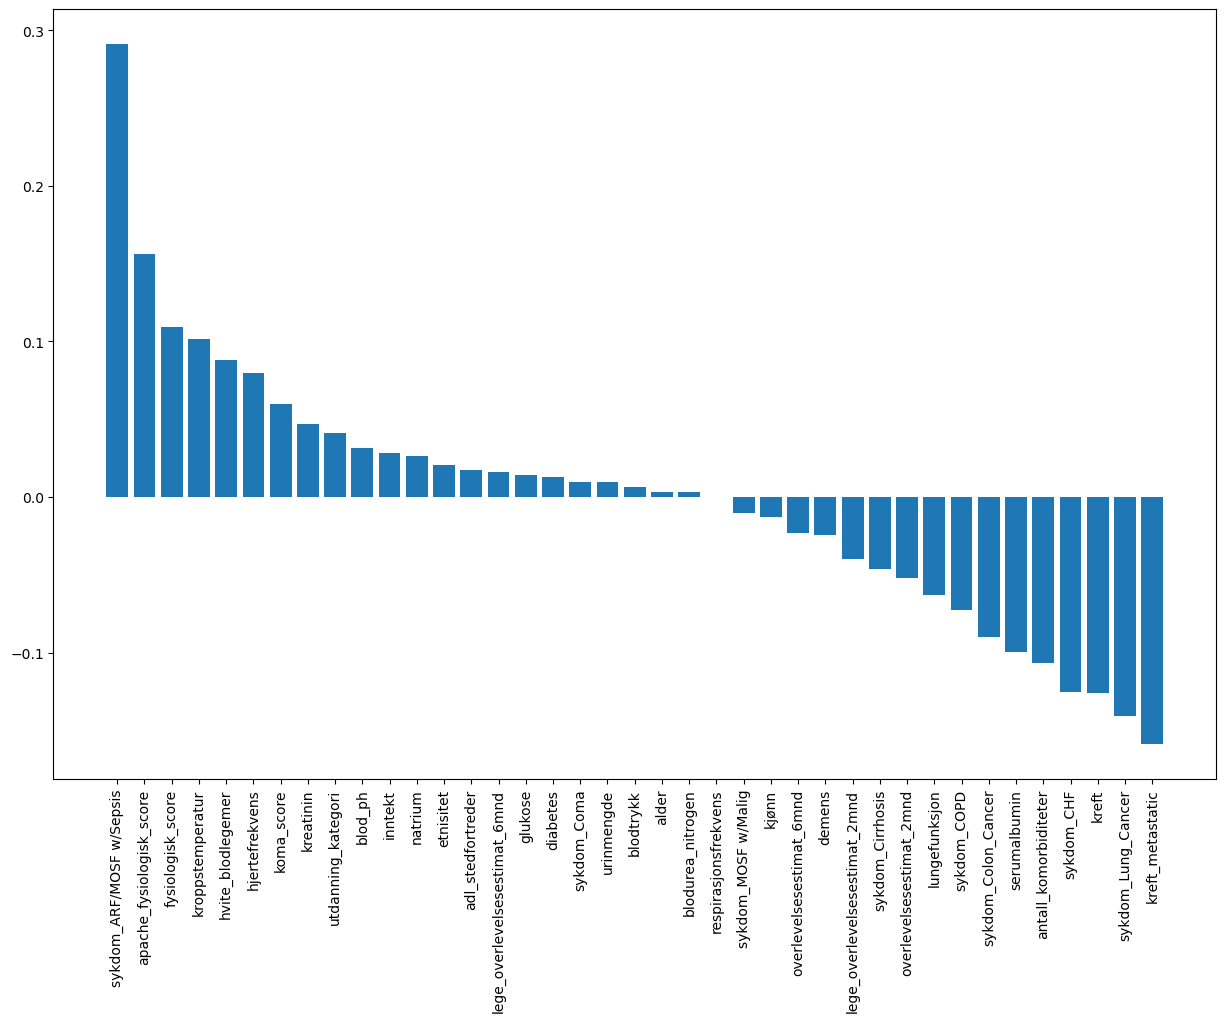

In [1643]:
correlation=train_df.corr()
corr_target=correlation['oppholdslengde'].sort_values(ascending=False)
corr_target.drop('oppholdslengde', inplace=True)

plt.figure(figsize=(15,10))
plt.bar(corr_target.index, corr_target.values)
plt.xticks(rotation=90)


plt.show()

In [1644]:
# Litt dprlig å bruke korrelasjon når vi har binære og kontinuerlige variabler, men lar den stå for nå. 
# Den fanger opp linær antagelse, og sammenheng mellom to variabler. 
# Hvis du prøver å se sammenhengen mellom en sykdom (som er binær: tilstedeværende eller ikke tilstedeværende) 
# og antall dager på sykehuset (kontinuerlig), er ikke forholdet nødvendigvis lineært. 
# For eksempel kan det være en terskel hvor tilstedeværelsen av en sykdom kraftig øker oppholdslengden, men det er ikke en jevn økning.

correlation_matrix=train_df.corr()

fig =px.imshow(correlation_matrix,
               labels=dict(x='Features', y='Features', color='Correlation'),
               x=correlation_matrix.columns,
               y=correlation_matrix.columns,
                color_continuous_scale='RdBu_r',
                aspect='auto')

fig.update_layout(
    yaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),
    autosize=False,
    height=1000,
    width=1000

)
fig.show()

## 4.1 NaN verdier

#### 4.1.1 Ser at jeg har verdier med høy korrelasjon, prøver å slå sammen for å se om det gjør en forskjell
#### For overlevelsesestimater

In [1645]:
if merge_overlevelsesestimater: 
    train_df['overlevelsesestimat'] = (train_df['overlevelsesestimat_2mnd'] + train_df['overlevelsesestimat_6mnd']) / 2
    val_df['overlevelsesestimat'] = (val_df['overlevelsesestimat_2mnd'] + val_df['overlevelsesestimat_6mnd']) / 2
    test_df['overlevelsesestimat'] = (test_df['overlevelsesestimat_2mnd'] + test_df['overlevelsesestimat_6mnd']) / 2

    train_df.drop(columns=['overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd'], inplace=True)
    val_df.drop(columns=['overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd'], inplace=True)
    test_df.drop(columns=['overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd'], inplace=True)

    train_df['lege_overlevelsesestimat'] = (train_df['lege_overlevelsesestimat_2mnd'] + train_df['lege_overlevelsesestimat_6mnd']) / 2
    val_df['lege_overlevelsesestimat'] = (val_df['lege_overlevelsesestimat_2mnd'] + val_df['lege_overlevelsesestimat_6mnd']) / 2
    test_df['lege_overlevelsesestimat'] = (test_df['lege_overlevelsesestimat_2mnd'] + test_df['lege_overlevelsesestimat_6mnd']) / 2
    


#### For kreft

In [1646]:
if merge_cancer:
    # For train_df
    train_df['has_lung_cancer'] = train_df['sykdom_Lung_Cancer'].astype(int)
    train_df['has_colon_cancer'] = train_df['sykdom_Colon_Cancer'].astype(int)
    train_df['kreft'] = train_df['kreft'].astype(int)

    train_df['has_any_cancer'] = (
        train_df['has_lung_cancer'] |
        train_df['has_colon_cancer'] |
        train_df['kreft']
    ).astype(int)

    # For val_df
    val_df['has_lung_cancer'] = val_df['sykdom_Lung_Cancer'].astype(int)
    val_df['has_colon_cancer'] = val_df['sykdom_Colon_Cancer'].astype(int)
    val_df['kreft'] = val_df['kreft'].astype(int)

    val_df['has_any_cancer'] = (
        val_df['has_lung_cancer'] |
        val_df['has_colon_cancer'] |
        val_df['kreft']
    ).astype(int)

    # For test_df
    test_df['has_lung_cancer'] = test_df['sykdom_Lung_Cancer'].astype(int)
    test_df['has_colon_cancer'] = test_df['sykdom_Colon_Cancer'].astype(int)
    test_df['kreft'] = test_df['kreft'].astype(int)

    test_df['has_any_cancer'] = (
        test_df['has_lung_cancer'] |
        test_df['has_colon_cancer'] |
        test_df['kreft']
    ).astype(int)

    # Drop original cancer columns and intermediate cancer columns
    columns_to_drop = ['sykdom_Lung_Cancer', 'sykdom_Colon_Cancer', 'kreft', 'has_lung_cancer', 'has_colon_cancer']

    train_df.drop(columns=columns_to_drop, axis=1, inplace=True)
    val_df.drop(columns=columns_to_drop, axis=1, inplace=True)
    test_df.drop(columns=columns_to_drop, axis=1, inplace=True)


### 4.2.1 Sjekker for NaN og fyller inn, hvis dem er missing at random place, sjekker jeg opp mot min beste modell den beste måten å fylle inn, hvis ikke må jeg se om det er noen sammenhenger eller andre verdier som er hensiktsmessig å fylle inn. 

In [1647]:
train_df.isnull().sum()

alder                               5
inntekt                          1763
etnisitet                           0
blodtrykk                           0
hvite_blodlegemer                 118
hjertefrekvens                      0
respirasjonsfrekvens                0
kroppstemperatur                    0
lungefunksjon                    1351
serumalbumin                     1976
kreatinin                          35
natrium                             0
blod_ph                          1328
glukose                          2680
blodurea_nitrogen                2588
urinmengde                       2871
antall_komorbiditeter               0
koma_score                          0
adl_stedfortreder                1702
fysiologisk_score                   0
apache_fysiologisk_score            0
overlevelsesestimat_2mnd            0
overlevelsesestimat_6mnd            0
diabetes                            0
demens                              0
lege_overlevelsesestimat_2mnd     990
lege_overlev

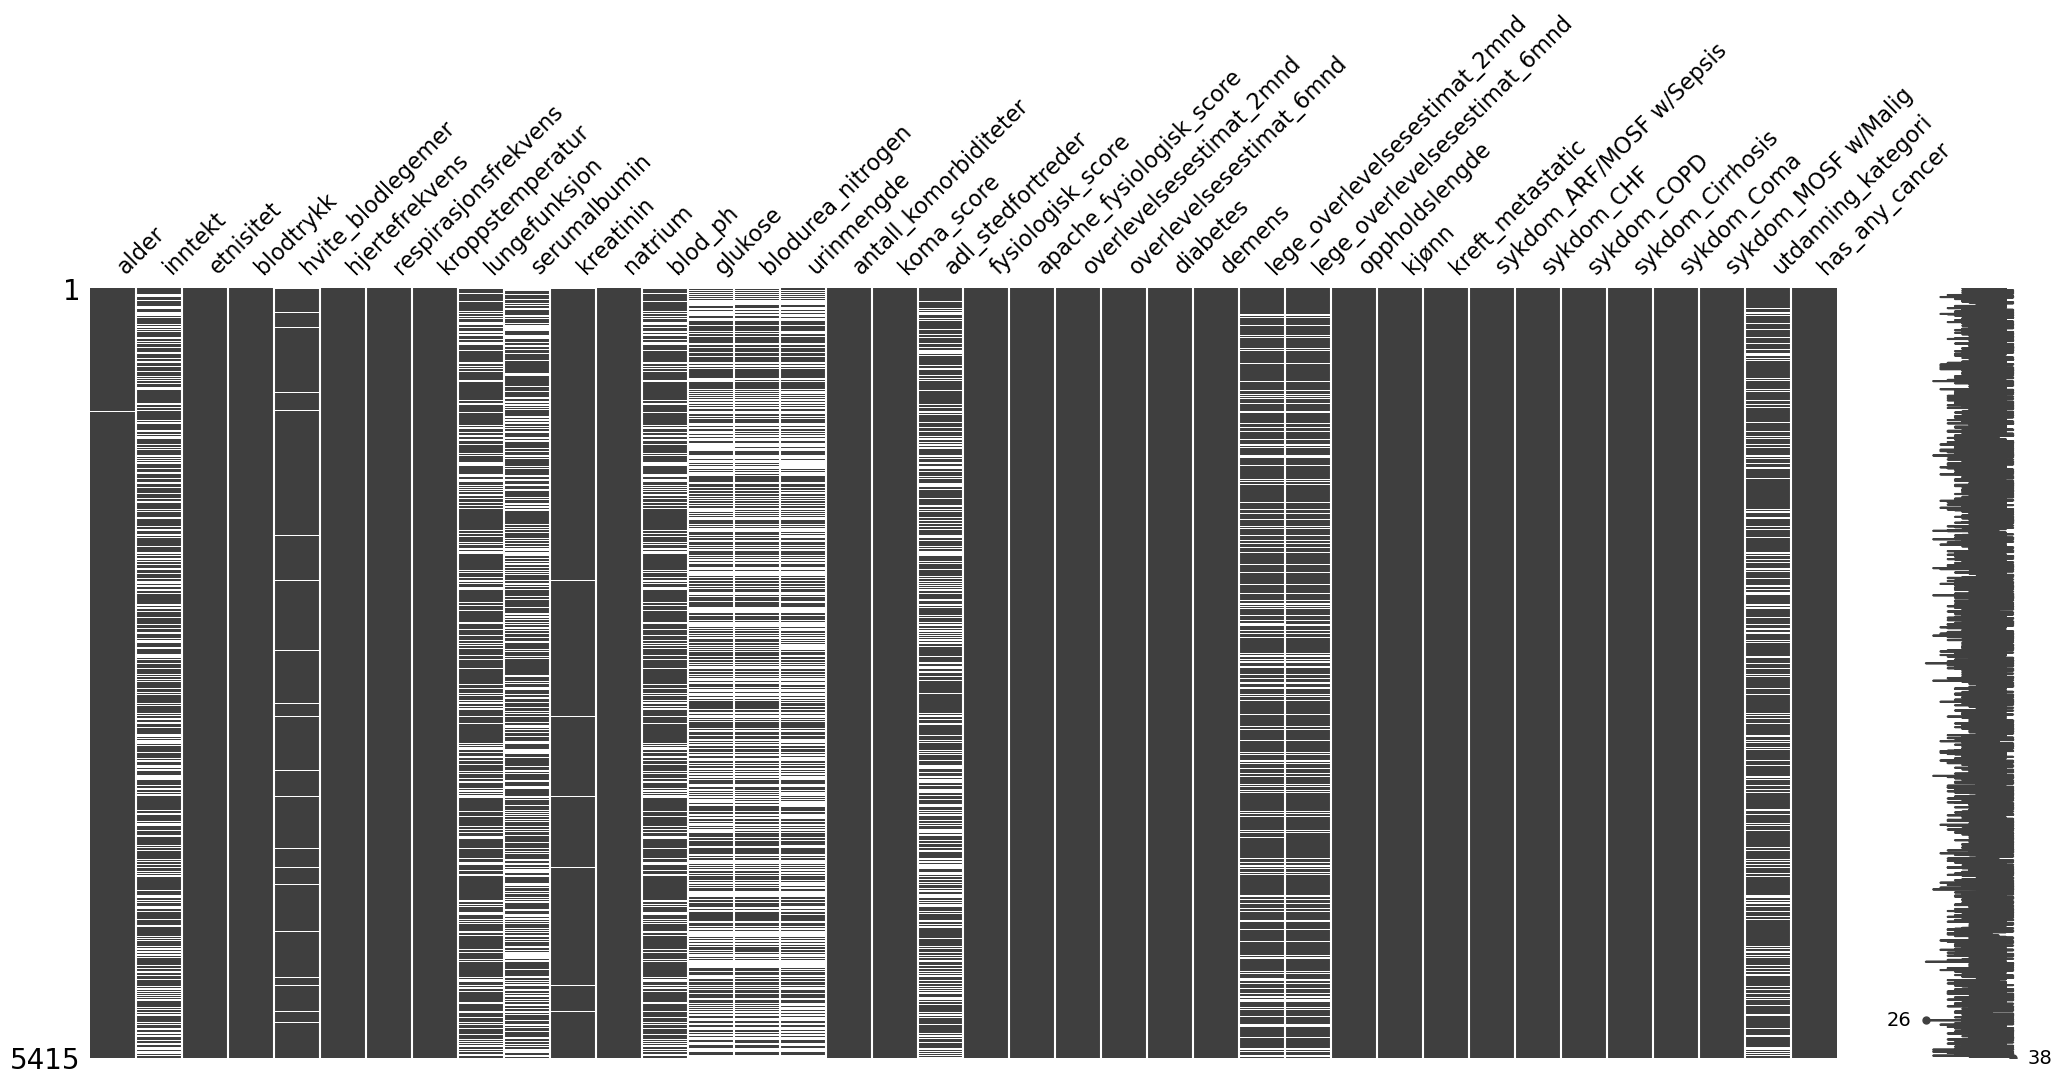

<Figure size 300x300 with 0 Axes>

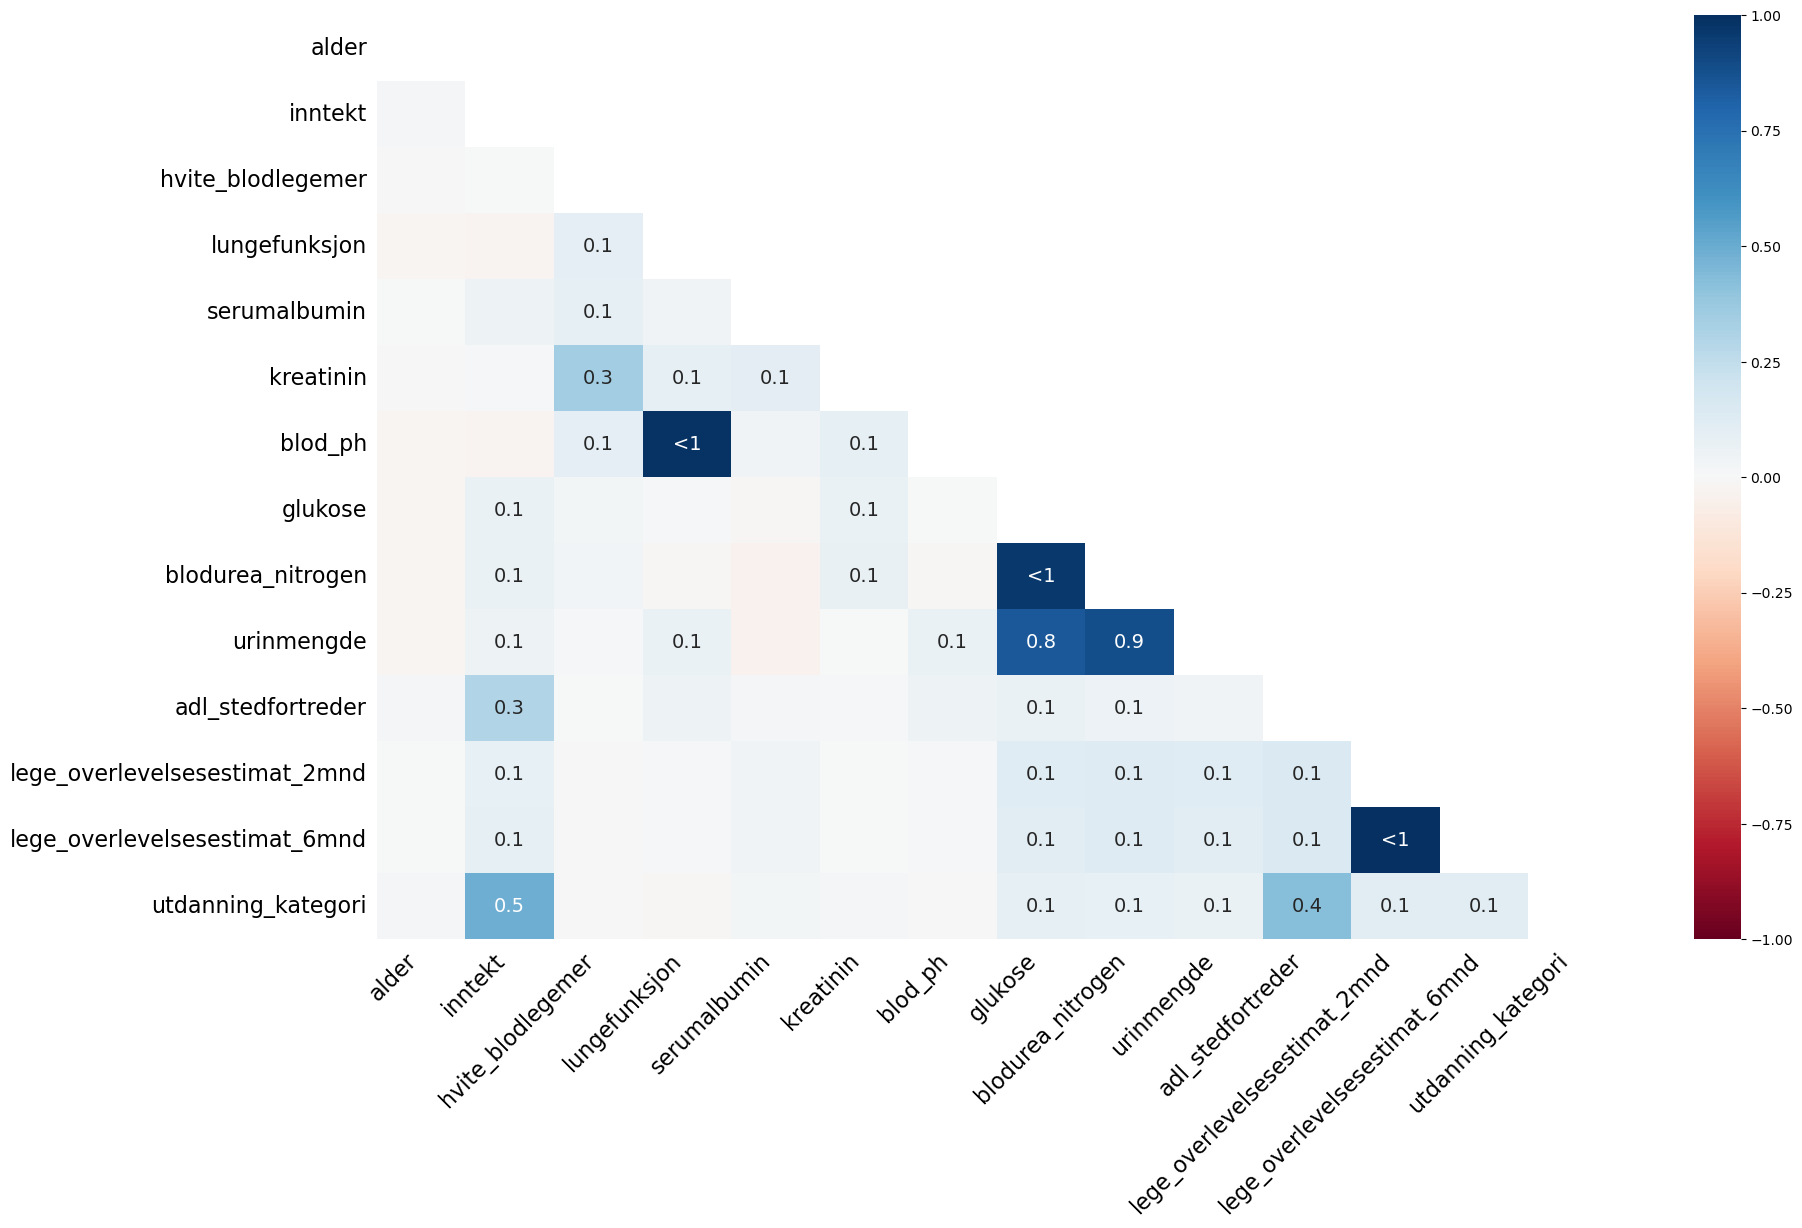

In [1648]:
import missingno as msno

msno.matrix(train_df)

plt.figure(figsize=(3, 3))
msno.heatmap(train_df)
plt.show()

#### 4.2.2 Ser på blod_ph og lungefunksjon

In [1649]:
train_df[['blod_ph', 'lungefunksjon']].head()

,blod_ph,lungefunksjon
0,7.389648,353.31250
1,7.489258,182.50000
2,7.239258,224.00000
3,NaN,NaN
4,7.339844,151.40625


In [1650]:
train_df.loc[:, 'blod_ph'] = train_df['blod_ph'].fillna(7.40)
val_df.loc[:, 'blod_ph'] = val_df['blod_ph'].fillna(7.40)
test_df.loc[:, 'blod_ph'] = test_df['blod_ph'].fillna(7.40)

In [1651]:
train_df['blod_ph'] = pd.cut(train_df['blod_ph'],
                             bins=[-float('inf'), 7.35, 7.45, float('inf')],
                             labels=[1, 0, 1], ordered=False)
train_df['blod_ph'] = train_df['blod_ph'].astype(float)

val_df['blod_ph'] = pd.cut(val_df['blod_ph'],
                           bins=[-float('inf'), 7.35, 7.45, float('inf')],
                           labels=[1, 0, 1], ordered=False)
val_df['blod_ph'] = val_df['blod_ph'].astype(float)

test_df['blod_ph'] = pd.cut(test_df['blod_ph'],
                            bins=[-float('inf'), 7.35, 7.45, float('inf')],
                            labels=[1, 0, 1], ordered=False)
test_df['blod_ph'] = test_df['blod_ph'].astype(float)

In [1652]:
train_df.loc[:, 'lungefunksjon'] = train_df['lungefunksjon'].fillna(333.3)
val_df.loc[:, 'lungefunksjon'] = val_df['lungefunksjon'].fillna(333.3)
test_df.loc[:, 'lungefunksjon'] = test_df['lungefunksjon'].fillna(333.3)

In [1653]:
# Del lungefunksjon inn i bins
train_df['lungefunksjon'] = pd.cut(train_df['lungefunksjon'], 
                                       bins=[-float('inf'), 300, float('inf')], 
                                       labels=[1, 0], 
                                       include_lowest=True)
val_df['lungefunksjon'] = pd.cut(val_df['lungefunksjon'], 
                                     bins=[-float('inf'), 300, float('inf')], 
                                     labels=[1, 0], 
                                     include_lowest=True)
test_df['lungefunksjon'] = pd.cut(test_df['lungefunksjon'], 
                                      bins=[-float('inf'), 300, float('inf')], 
                                      labels=[1, 0], 
                                      include_lowest=True)

train_df['lungefunksjon'] = train_df['lungefunksjon'].astype(int)
val_df['lungefunksjon'] = val_df['lungefunksjon'].astype(int)
test_df['lungefunksjon'] = test_df['lungefunksjon'].astype(int)

#### 4.2.3 Glukose og Bloduera nitrogen

In [1654]:
print(train_df[['blodurea_nitrogen', 'glukose', 'diabetes']].head(n=20))

    blodurea_nitrogen  glukose  diabetes
0                43.0     80.0         0
1                19.0     94.0         0
2                 NaN      NaN         0
3                 NaN      NaN         0
4                 NaN      NaN         0
5                38.0    115.0         1
6                 NaN      NaN         1
7                27.0    145.0         0
8                 NaN      NaN         0
9                 NaN      NaN         0
10               31.0    257.0         0
11                NaN      NaN         0
12                NaN      NaN         0
13               31.0    151.0         1
14                6.0     69.0         0
15               11.0    125.0         0
16               34.0     88.0         0
17                NaN      NaN         1
18               27.0    127.0         0
19                NaN      NaN         0


In [1655]:
train_df.loc[:, 'blodurea_nitrogen'] = train_df['blodurea_nitrogen'].fillna(15)
val_df.loc[:, 'blodurea_nitrogen'] = val_df['blodurea_nitrogen'].fillna(15)
test_df.loc[:, 'blodurea_nitrogen'] = test_df['blodurea_nitrogen'].fillna(15)

In [1656]:
train_df['blodurea_nitrogen'] = pd.cut(train_df['blodurea_nitrogen'],
                             bins=[-float('inf'), 6, 24, float('inf')],
                             labels=[1, 0, 1], ordered=False)
train_df['blodurea_nitrogen'] = train_df['blodurea_nitrogen'].astype(float)

val_df['blodurea_nitrogen'] = pd.cut(val_df['blodurea_nitrogen'],
                           bins=[-float('inf'), 6, 24, float('inf')],
                           labels=[1, 0, 1], ordered=False)
val_df['blodurea_nitrogen'] = val_df['blodurea_nitrogen'].astype(float)

test_df['blodurea_nitrogen'] = pd.cut(test_df['blodurea_nitrogen'],
                            bins=[-float('inf'), 6, 24, float('inf')],
                            labels=[1, 0, 1], ordered=False)
test_df['blodurea_nitrogen'] = test_df['blodurea_nitrogen'].astype(float)

In [1657]:
train_df.loc[:, 'glukose'] = train_df['glukose'].fillna(85)
val_df.loc[:, 'glukose'] = val_df['glukose'].fillna(85)
test_df.loc[:, 'glukose'] = test_df['glukose'].fillna(85)

In [1658]:
train_df['glukose'] = pd.cut(train_df['glukose'],
                             bins=[-float('inf'), 70, 100, float('inf')],
                             labels=[1, 0, 1], ordered=False)
train_df['glukose'] = train_df['glukose'].astype(float)

val_df['glukose'] = pd.cut(val_df['glukose'],
                           bins=[-float('inf'), 70, 100, float('inf')],
                           labels=[1, 0, 1], ordered=False)
val_df['glukose'] = val_df['glukose'].astype(float)

test_df['glukose'] = pd.cut(test_df['glukose'],
                            bins=[-float('inf'), 70, 100, float('inf')],
                            labels=[1, 0, 1], ordered=False)
test_df['glukose'] = test_df['glukose'].astype(float)

#### 4.2.4 Urinmengde, glukose og bloduera_nitrogen

In [1659]:
train_df.loc[:, 'urinmengde'] = train_df['urinmengde'].fillna(2502)
val_df.loc[:, 'urinmengde'] = val_df['urinmengde'].fillna(2502)
test_df.loc[:, 'urinmengde'] = test_df['urinmengde'].fillna(2502)

In [1660]:
train_df['urinmengde'] = pd.cut(train_df['urinmengde'],
                                bins=[-float('inf'), 2500, 2502, float('inf')],
                                labels=[1, 0, 1], ordered=False)
train_df['urinmengde'] = train_df['urinmengde'].astype(float)

val_df['urinmengde'] = pd.cut(val_df['urinmengde'],
                              bins=[-float('inf'), 2500, 2502, float('inf')],
                              labels=[1, 0, 1], ordered=False)
val_df['urinmengde'] = val_df['urinmengde'].astype(float)

test_df['urinmengde'] = pd.cut(test_df['urinmengde'],
                               bins=[-float('inf'), 2500, 2502, float('inf')],
                               labels=[1, 0, 1], ordered=False)
test_df['urinmengde'] = test_df['urinmengde'].astype(float)


#### Setter sammen disse funksjonene som er viktig for nyre og diabetes

In [1661]:
if nyre_diabetes_merge:
    train_df['unormale_målinger'] = train_df['urinmengde'] + train_df['blodurea_nitrogen'] + train_df['glukose']
    val_df['unormale_målinger'] = val_df['urinmengde'] + val_df['blodurea_nitrogen'] + val_df['glukose']
    test_df['unormale_målinger'] = test_df['urinmengde'] + test_df['blodurea_nitrogen'] + test_df['glukose']

    train_df.drop(columns=['urinmengde', 'blodurea_nitrogen', 'glukose'], inplace=True)
    val_df.drop(columns=['urinmengde', 'blodurea_nitrogen', 'glukose'], inplace=True)
    test_df.drop(columns=['urinmengde', 'blodurea_nitrogen', 'glukose'], inplace=True)
    



#### 4.2.5 Fyller inn resterende NaN verdier med en enkel imputering, eller anbefalte verdier for å teste ut flere ulike modeller. 

##### Må dele opp train, val og test igjen først. 

In [1662]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   alder                          1155 non-null   float64
 1   inntekt                        795 non-null    float64
 2   etnisitet                      1160 non-null   int64  
 3   blodtrykk                      1160 non-null   float64
 4   hvite_blodlegemer              1125 non-null   float64
 5   hjertefrekvens                 1160 non-null   float64
 6   respirasjonsfrekvens           1160 non-null   float64
 7   kroppstemperatur               1160 non-null   float64
 8   lungefunksjon                  1160 non-null   int64  
 9   serumalbumin                   732 non-null    float64
 10  kreatinin                      1149 non-null   float64
 11  natrium                        1160 non-null   float64
 12  blod_ph                        1160 non-null   f

##### Må dele opp train,val og test for å bruke videre

In [1663]:
X_train = train_df.drop(columns=['oppholdslengde']) 
y_train = train_df['oppholdslengde']                 

X_val = val_df.drop(columns=['oppholdslengde'])      
y_val = val_df['oppholdslengde']                     

X_test = test_df.drop(columns=['oppholdslengde'])    
y_test = test_df['oppholdslengde']     


X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
y_val_copy = y_val.copy()
X_val_copy = X_val.copy()

## 4.3.1 finner beste imputasjon for modellene og deres beste hyper parametere

In [1664]:
#Sjekker for flere 

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


extraTree = ExtraTreesRegressor(max_depth=50, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=400)
mlp = MLPRegressor(activation='relu', alpha=0.001, hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001, solver='adam', max_iter=500)
gradient = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=5, min_samples_split=2, subsample=1.0, alpha=0.9)

param_grids = {
    'ExtraTreesRegressor': {
        'model__n_estimators': [400],
        'model__max_depth': [20],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [5],
        'model__max_features': [0.5]
    },
    'GradientBoostingRegressor': {
        'model__n_estimators': [100],  
        'model__learning_rate': [0.1],
        'model__max_depth': [3],
        'model__max_features': ['log2'],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [5],
        'model__subsample': [1.0],
        'model__alpha': [0.9]
    },
    'MLPRegressor': {
        'model__activation': ['relu'],
        'model__alpha': [0.001],
        'model__hidden_layer_sizes': [(100,)],
        'model__learning_rate': ['constant'],
        'model__learning_rate_init': [0.001],
        'model__solver': ['adam'],
        'model__max_iter': [500]
    }
}

imputers = {
    'SimpleMean': SimpleImputer(strategy='mean'),
    'SimpleMedian': SimpleImputer(strategy='median'),
    'SimpleMostFrequent': SimpleImputer(strategy='most_frequent'),
    'KNN50': KNNImputer(n_neighbors=50),
    'KNN100': KNNImputer(n_neighbors=100),
    'KNN150': KNNImputer(n_neighbors=150),  
}


if run_grid_search_forAll:
    # Prepare models for iteration
    models = [
        ('ExtraTreesRegressor', extraTree),
        ('GradientBoostingRegressor', gradient),
        ('MLPRegressor', mlp)
    ]

    # Prepare results storage
    results = []

    # Loop over imputers and models
    for imputer_name, imputer in imputers.items():
        for model_name, model in models:

            # Create a pipeline with the imputer and model
            pipeline = Pipeline([
                ('imputer', imputer),
                ('model', model)
            ])

            # Get the parameter grid for the current model
            param_grid = param_grids[model_name]
            cv=KFold(n_splits=5, shuffle=True, random_state=42)

            # Use GridSearchCV to find the best hyperparameters
            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                cv=cv,  # 5-fold cross-validation
                scoring='neg_mean_squared_error',
                n_jobs=-1,  # Use all available cores
                verbose=1
            )

            # Before fitting the model, apply the imputer on X_train and X_val datasets
            if imputer_name.startswith("KNN"):
                # Specific case for KNNImputer with n_neighbors for NaN values
                imputer_transformer = KNNImputer(n_neighbors=int(imputer_name.replace('KNN', '')))
            else:
                imputer_transformer = imputer

            X_train_imputed = imputer_transformer.fit_transform(X_train_copy)
            X_val_imputed = imputer_transformer.transform(X_val_copy)

            X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_copy.columns)
            X_val_imputed = pd.DataFrame(X_val_imputed, columns=X_val_copy.columns)

            # Fit GridSearchCV
            grid_search.fit(X_train_imputed, y_train_copy)

            # Best model after grid search
            best_model = grid_search.best_estimator_

            # Predict on validation set
            y_pred = best_model.predict(X_val_imputed)

            # Calculate RMSE on validation set
            rmse = np.sqrt(mean_squared_error(y_val_copy, y_pred))

            # Store the results
            results.append({
                'Imputer': imputer_name,
                'Model': model_name,
                'Best Params': grid_search.best_params_,
                'RMSE': rmse
            })

    # Convert the results to a DataFrame and display sorted by RMSE
    results_df = pd.DataFrame(results).sort_values(by='RMSE')
    
    # Display only relevant columns (without hyperparameters)
    results_df_clean = results_df[['Imputer', 'Model', 'RMSE']].sort_values(by='RMSE')
    print(results_df_clean)




In [1665]:
if cross_validation:
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import mean_squared_error
    import numpy as np
    import pandas as pd

    # Define models
    extraTree = ExtraTreesRegressor(max_depth=50, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=450, random_state=42)
    mlp = MLPRegressor(activation='relu', alpha=0.0001, hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001, solver='adam', random_state=42)
    gradient = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=5, min_samples_split=2, subsample=1.0, random_state=42)

    # Define imputers
    imputers = {
        'SimpleMean': SimpleImputer(strategy='mean'),
        'SimpleMedian': SimpleImputer(strategy='median'),
        'SimpleMostFrequent': SimpleImputer(strategy='most_frequent'),
        'KNN50': KNNImputer(n_neighbors=50),
        'KNN100': KNNImputer(n_neighbors=100),
        'KNN150': KNNImputer(n_neighbors=150),  
    }

    # Define models (including several)
    models = [
        tree.DecisionTreeRegressor(random_state=42),
        gradient,
        extraTree,
    ]

    # Result storage
    results = []

    # Cross-validation loop over imputers and models
    for imputer_name, imputer in imputers.items():
        for model in models:
            # Create pipeline with the imputer and model
            pipeline = Pipeline([
                ('imputer', imputer),
                ('model', model)
            ])

            # Calculate RMSE using cross-validation (5 folds)
            scores = cross_val_score(pipeline, X_train_copy, y_train_copy, cv=5, scoring='neg_mean_squared_error')

            # Average RMSE from 5 folds
            avg_rmse = np.mean(np.sqrt(-scores))

            # Store the results
            results.append({
                'Imputer': imputer_name,
                'Model': model.__class__.__name__,
                'RMSE': avg_rmse
            })

    # Convert the results to DataFrame and sort by RMSE
    results_df = pd.DataFrame(results).sort_values(by='RMSE')
    
    # Print the sorted results DataFrame
    print(results_df)


In [1666]:
if cross_validation:

    top_5_results = results_df.nsmallest(5, 'RMSE')

    fig = px.line(
        results_df, 
        x='Imputer',  # X-axis: Imputer
        y='RMSE',     # Y-axis: RMSE
        color='Model', # Different lines for each model
        title='RMSE for 5 beste Imputers og Modeller'
    )

# Display the plot
    fig.show()

In [1667]:
if fill_in_mean:
    imputer = SimpleImputer(strategy='mean')

    # Fyll manglende verdier i X_train
    X_train = imputer.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns=train_df.drop('oppholdslengde', axis=1).columns)

    # Fyll manglende verdier i X_val og X_test
    X_val = imputer.transform(X_val)
    X_val = pd.DataFrame(X_val, columns=val_df.drop('oppholdslengde', axis=1).columns)

    X_test = imputer.transform(X_test)
    X_test = pd.DataFrame(X_test, columns=test_df.drop('oppholdslengde', axis=1).columns)

    train_df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
    val_df = pd.concat([X_val, y_val.reset_index(drop=True)], axis=1)
    test_df = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

train_df.isnull().sum() 

alder                               5
inntekt                          1763
etnisitet                           0
blodtrykk                           0
hvite_blodlegemer                 118
hjertefrekvens                      0
respirasjonsfrekvens                0
kroppstemperatur                    0
lungefunksjon                       0
serumalbumin                     1976
kreatinin                          35
natrium                             0
blod_ph                             0
glukose                             0
blodurea_nitrogen                   0
urinmengde                          0
antall_komorbiditeter               0
koma_score                          0
adl_stedfortreder                1702
fysiologisk_score                   0
apache_fysiologisk_score            0
overlevelsesestimat_2mnd            0
overlevelsesestimat_6mnd            0
diabetes                            0
demens                              0
lege_overlevelsesestimat_2mnd     990
lege_overlev

In [1668]:
from sklearn.impute import KNNImputer

if fill_in_knn:
    # Initialiser KNN-imputer
    imputer = KNNImputer(n_neighbors=100)  # Du kan justere 'n_neighbors'

    # Fyll manglende verdier i X_train
    X_train = imputer.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns=train_df.drop('oppholdslengde', axis=1).columns)

    # Fyll manglende verdier i X_val og X_test
    X_val = imputer.transform(X_val)
    X_val = pd.DataFrame(X_val, columns=val_df.drop('oppholdslengde', axis=1).columns)

    X_test = imputer.transform(X_test)
    X_test = pd.DataFrame(X_test, columns=test_df.drop('oppholdslengde', axis=1).columns)


## 5.1.1 Modellering

#### 5.1.1 Grunnlinjemodell

In [1669]:
baseline = DummyRegressor(strategy='mean') 
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_val)
rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred_baseline))
 
score = {}
score["actual"] = y_val
score["baseline"] = y_pred_baseline 

print(f"RMSE for baseline: {rmse_baseline}")

RMSE for baseline: 21.49734548333088


#### 5.1.2 Tester ulike modeller

In [1670]:
models = [tree.DecisionTreeRegressor(random_state=42), ensemble.GradientBoostingRegressor(random_state=42), ensemble.ExtraTreesRegressor(random_state=42), 
          ensemble.RandomForestRegressor(random_state=42),neural_network.MLPRegressor(random_state=42),linear_model.Lasso(random_state=42)]

bestmodel = []
best_rmse = rmse_baseline

#X_val = pd.DataFrame(X_val, columns=X_train.columns)

for reg in models:
    reg.fit(X_train, y_train)
    reg_pred = reg.predict(X_val) 
    reg_score = float(np.sqrt(metrics.mean_squared_error(y_val, reg_pred)))
    if reg_score <= best_rmse:
        best_rmse = reg_score
        bestmodel = reg    
    print("model: " + str(reg) + " , score is " + str(reg_score))

model: DecisionTreeRegressor(random_state=42) , score is 29.460186459133222
model: GradientBoostingRegressor(random_state=42) , score is 20.199365494029294
model: ExtraTreesRegressor(random_state=42) , score is 20.50368633172228
model: RandomForestRegressor(random_state=42) , score is 20.386845777997685
model: MLPRegressor(random_state=42) , score is 20.114671639700372
model: Lasso(random_state=42) , score is 20.531937387281197


#### 5.2.1 Grunnlinjemodell Log

In [1671]:
y_train_log = np.log(y_train)

baseline_log = DummyRegressor(strategy='mean') 
baseline_log.fit(X_train, y_train_log)

y_pred_log = baseline_log.predict(X_val)
y_pred = np.exp(y_pred_log)  
rmse_log = np.sqrt(mean_squared_error(y_val, y_pred))
mae_log = mean_absolute_error(y_val, y_pred)

print(f"RMSE med log-transformasjon: {rmse_log}")

X_train

RMSE med log-transformasjon: 22.39396920687584


,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Coma,sykdom_MOSF w/Malig,utdanning_kategori,has_any_cancer
0,60.33899,0.80,0.0,60.0,7.899414,130.0,26.0,38.00000,0.0,2.499819,6.199219,134.0,0.0,0.0,1.0,1.0,1.0,0.0,0.00,40.796875,54.0,0.282959,0.173981,0.0,0.0,0.40,0.30,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0
1,52.74698,0.00,0.0,73.0,10.599609,65.0,7.0,36.50000,1.0,3.413748,1.399902,138.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,17.597656,17.0,0.858887,0.809937,0.0,0.0,0.90,0.90,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,42.38498,0.77,0.0,102.0,11.000000,66.0,24.0,35.69531,1.0,3.899902,1.199951,131.0,1.0,0.0,0.0,0.0,3.0,0.0,1.65,18.000000,29.0,0.843994,0.743896,0.0,0.0,0.80,0.60,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.97,0.0
3,79.88495,0.00,0.0,61.0,11.233707,96.0,20.0,36.39844,0.0,3.266790,2.058857,140.0,0.0,0.0,0.0,1.0,2.0,0.0,1.00,21.000000,40.0,0.756958,0.614990,0.0,0.0,0.95,0.60,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0
4,93.01599,0.62,0.0,114.0,12.298828,75.0,32.0,39.09375,1.0,4.599609,0.799927,131.0,1.0,0.0,0.0,0.0,0.0,61.0,0.00,23.296875,41.0,0.312988,0.240997,0.0,0.0,0.30,0.20,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410,46.97598,1.00,1.0,83.0,11.199219,78.0,28.0,35.39844,0.0,3.099609,1.099854,134.0,0.0,0.0,0.0,0.0,3.0,0.0,0.00,24.097656,18.0,0.890991,0.817993,0.0,0.0,1.00,0.95,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.00,0.0
5411,49.48099,0.00,0.0,103.0,7.599609,189.0,30.0,36.19531,1.0,3.099609,0.799927,137.0,1.0,0.0,0.0,0.0,2.0,0.0,1.58,25.000000,39.0,0.684937,0.517944,0.0,0.0,0.90,0.60,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,1.0
5412,82.20898,3.00,0.0,108.0,17.699219,115.0,28.0,36.00000,0.0,1.899902,1.199951,135.0,0.0,1.0,0.0,1.0,0.0,0.0,5.00,30.000000,62.0,0.744995,0.665894,0.0,0.0,0.90,0.90,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.00,0.0
5413,77.46997,1.08,0.0,71.0,24.296875,119.0,32.0,36.79688,1.0,2.399902,1.199951,136.0,1.0,1.0,1.0,1.0,1.0,0.0,4.00,16.898438,8.0,0.725952,0.451965,0.0,0.0,0.70,0.60,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1.0


#### Sjekker for flere type modeller for log 

In [1672]:
y_train_log = np.log(y_train)

models = [
    tree.DecisionTreeRegressor(random_state=42),
    ensemble.GradientBoostingRegressor(random_state=42),
    ensemble.ExtraTreesRegressor(random_state=42),
    ensemble.RandomForestRegressor(random_state=42),
    neural_network.MLPRegressor(random_state=42),
    linear_model.Lasso(random_state=42)
]

bestmodel = None
best_rmse = rmse_log

X_val = pd.DataFrame(X_val, columns=X_train.columns)

for reg in models:
    reg.fit(X_train, y_train_log)  
    reg_pred_log = reg.predict(X_val)  
    reg_pred = np.exp(reg_pred_log) 

    reg_score = np.sqrt(metrics.mean_squared_error(y_val, reg_pred))

    if reg_score <= best_rmse:
        best_rmse = reg_score
        bestmodel = reg

    print(f"Model: {str(reg)} , RMSE: {reg_score}")

print(f"The best model is: {str(bestmodel)} with RMSE: {best_rmse}")


Model: DecisionTreeRegressor(random_state=42) , RMSE: 28.670692713808908
Model: GradientBoostingRegressor(random_state=42) , RMSE: 20.55959223064104
Model: ExtraTreesRegressor(random_state=42) , RMSE: 20.58177543339098
Model: RandomForestRegressor(random_state=42) , RMSE: 20.546090139487614
Model: MLPRegressor(random_state=42) , RMSE: 21.03625596700144
Model: Lasso(random_state=42) , RMSE: 22.224264448558884
The best model is: RandomForestRegressor(random_state=42) with RMSE: 20.546090139487614


## 5.3.1 Finner beste hyper parameter for modellene som gir best resultat på enkel imputasjon for NaN


#### 5.3.2 GradientBoosting

In [1673]:
if gradientBoosting_first:
    param_grid = {
        'learning_rate': [0.1], 
        'max_depth': [3], 
        'max_features': ['log2'], 
        'min_samples_leaf': [5],  
        'min_samples_split': [2],  
        'subsample': [1.0],  
        'alpha': [0.9]  
    }

    model = GradientBoostingRegressor(random_state=42)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,  
        n_jobs=-1, 
        verbose=1, 
        scoring='neg_mean_squared_error'  
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")
    y_pred_gb = grid_search.best_estimator_.predict(X_val)
    rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gb))
    print(f"RMSE på valideringssettet: {rmse_gb}")


#### Printer ut forhold mellom de faktiske verdiene og predikerte

In [1674]:
if gradientBoosting_first:
    df_val_pred = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (GradientBoosting)': y_pred_gb,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })


    fig_rf = px.scatter(df_val_pred, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (GradientBoosting)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (GradientBoosting)'},
                        title='Faktisk vs. Predikert oppholdslengde (GradientBoosting)')

    fig_rf.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))

    fig_rf.show()

##### Sjekker viktig informasjon for modellen

In [1675]:
model= GradientBoostingRegressor(random_state=42, alpha=0.9, learning_rate=0.05, loss='absolute_error', max_depth=5, max_features='sqrt', min_samples_leaf=5, min_samples_split=2, n_estimators=100, subsample=1.0)
# Trene modellen
model.fit(X_train, y_train)

# Få feature importances
importances = model.feature_importances_

# Lage en DataFrame for å vise feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sorter etter viktighet i synkende rekkefølge
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print listen av features med deres viktighet
print(feature_importance_df.to_string(index=False))



                      Feature  Importance
     sykdom_ARF/MOSF w/Sepsis    0.132335
     overlevelsesestimat_2mnd    0.096304
            fysiologisk_score    0.091726
     apache_fysiologisk_score    0.088972
     overlevelsesestimat_6mnd    0.088027
lege_overlevelsesestimat_2mnd    0.065782
lege_overlevelsesestimat_6mnd    0.049867
            adl_stedfortreder    0.049069
             kroppstemperatur    0.032881
                 serumalbumin    0.028325
                   koma_score    0.027370
             kreft_metastatic    0.024866
                        alder    0.021771
         respirasjonsfrekvens    0.020384
                    blodtrykk    0.019884
               hjertefrekvens    0.019049
                   sykdom_CHF    0.018473
            hvite_blodlegemer    0.017265
        antall_komorbiditeter    0.014976
                      natrium    0.012669
                      inntekt    0.011035
                    kreatinin    0.008826
                  sykdom_Coma    0

In [1676]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

fig = px.bar(feature_importance_df, x='Importance', y='Feature', orientation='h', title="Feature Importance")
fig.show()

#### MLP

In [1677]:
if mlp_first:
    param_grid = {
        'hidden_layer_sizes': [(100,)],  
        'activation': ['relu'],  
        'solver': ['adam'],  
        'alpha': [0.001], 
        'learning_rate': ['constant'],  
        'learning_rate_init': [0.001]
    }
    
    model = MLPRegressor(max_iter=1000, random_state=42, early_stopping=True)
    cv= KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,  
        n_jobs=-1,  
        verbose=1,  
        scoring='neg_mean_squared_error'  
    )
    
    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")

    y_pred_mlp = grid_search.best_estimator_.predict(X_val)

    rmse_mlp = np.sqrt(mean_squared_error(y_val, y_pred_mlp))
    print(f"RMSE på valideringssettet: {rmse_mlp}")

In [1678]:
if mlp_first:
    val_pred_df = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (MLP)': y_pred_mlp,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })

    fig_mlp = px.scatter(val_pred_df, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (MLP)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (MLP)'},
                        title='Faktisk vs. Predikert oppholdslengde (MLP)')

    fig_mlp.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))

    fig_mlp.show()


#### ExtraTree regressor

In [1679]:
if extraTrees_first: 
    param_grid = {
        'n_estimators': [400],
        'max_depth': [20],
        'min_samples_split': [2], 
        'min_samples_leaf': [5],  
        'max_features': [0.5]
    }

    model = ExtraTreesRegressor(random_state=42)
    
    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,  
        n_jobs=-1, 
        verbose=1,
        scoring='neg_mean_squared_error'
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")

    best_model_Et = grid_search.best_estimator_
    y_pred_et = best_model_Et.predict(X_val)

    rmse_et = np.sqrt(mean_squared_error(y_val, y_pred_et))
    print(f"RMSE på valideringssettet: {rmse_et}")

In [1680]:
if extraTrees_first:
    df = pd.DataFrame({
    'Faktisk oppholdslengde': y_val,
    'Predikert oppholdslengde (ETR)': y_pred_et,
    'Predikert oppholdslengde (Baseline)': y_pred_baseline
})


    fig_etr = px.scatter(df, 
                    x='Faktisk oppholdslengde', 
                    y='Predikert oppholdslengde (ETR)', 
                    labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (ETR)'},
                    title='Faktisk vs. Predikert oppholdslengde (ETR)')

    fig_etr.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                 line=dict(color='red', dash='dash'))

    fig_etr.show()


#### 5.3.2 Finner beste hyper parameter for log-modell

In [1681]:
from sklearn.ensemble import RandomForestRegressor


if RandomTree_log:
    param_grid = {
        'n_estimators': [400],
        'max_depth': [20],
        'min_samples_split': [2],
        'min_samples_leaf': [2],
        'oob_score': [True],
        'max_features': ['log2'],
    }
    
    model = RandomForestRegressor(random_state=42)
    cv = KFold(n_splits=4, shuffle=True, random_state=42)

    # Log-transformere y_train
    y_train_log = np.log(y_train)

    # Grid search med Random Forest
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,              
        n_jobs=-1,           
        verbose=1, 
    )
    
    grid_search.fit(X_train, y_train_log)  

    print(f"Beste parametere: {grid_search.best_params_}")

    y_pred_r_log = grid_search.best_estimator_.predict(X_val)
    y_pred_r = np.exp(y_pred_r_log)  

    rmse_t = np.sqrt(mean_squared_error(y_val, y_pred_r))
    print(f"RMSE på valideringssettet: {rmse_t}")


#### Visualiserer predikerte verdi opp mot den faktiske verdien. 

In [1682]:
# Opprett DataFrame med faktiske og predikerte verdier
if RandomTree_log:
    val_pred_df = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (RandomForest_log)': y_pred_r,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })

    # Plot Faktisk vs Predikert oppholdslengde (MLP)
    fig_RandomForest_log= px.scatter(val_pred_df, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (RandomForest_log)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (RandomForest_log)'},
                        title='Faktisk vs. Predikert oppholdslengde (RandomForest_log)')

    # Legg til en rød linje som representerer den ideelle "perfekte" prediksjonen
    fig_RandomForest_log.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))

    # Vis plot
    fig_RandomForest_log.show()


## Samler alle verdier 5.3.3

In [1683]:
'''
#extraTree = ExtraTreesRegressor(max_depth=20, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=400)
#mlp = MLPRegressor(activation='relu', alpha=0.001, hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001)
#gradient = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=5, min_samples_split=2, subsample=1.0)
randomTree_log = RandomForestRegressor(max_depth=20, max_features='log2', min_samples_leaf=2, min_samples_split=2, n_estimators=4000, oob_score=True)

models = [extraTree, mlp, gradient, randomTree_log]
model_rmse = {} 

for model in models:
    # For log-transformerte modeller (randomTree_log), log-transformer målet (y_train)
    if model == randomTree_log:
        y_train_log = np.log(y_train)
        model.fit(X_train, y_train_log)
        y_pred_log = model.predict(X_val)
        y_pred = np.exp(y_pred_log)  # Tilbake-transformer prediksjonene
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
    
    # Beregn MSE og deretter RMSE
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    
    model_rmse[model.__class__.__name__] = rmse
    print(f"{model.__class__.__name__} - RMSE: {rmse:.4f}")

# Finn den beste modellen basert på RMSE
best_model_name = min(model_rmse, key=model_rmse.get)
best_model = [model for model in models if model.__class__.__name__ == best_model_name][0]

print(f"\nBeste modell basert på RMSE på valideringssettet: {best_model_name} med RMSE: {model_rmse[best_model_name]:.4f}")
'''

'\n#extraTree = ExtraTreesRegressor(max_depth=20, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=400)\n#mlp = MLPRegressor(activation=\'relu\', alpha=0.001, hidden_layer_sizes=(100,), learning_rate=\'constant\', learning_rate_init=0.001)\n#gradient = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features=\'log2\', min_samples_leaf=5, min_samples_split=2, subsample=1.0)\nrandomTree_log = RandomForestRegressor(max_depth=20, max_features=\'log2\', min_samples_leaf=2, min_samples_split=2, n_estimators=4000, oob_score=True)\n\nmodels = [extraTree, mlp, gradient, randomTree_log]\nmodel_rmse = {} \n\nfor model in models:\n    # For log-transformerte modeller (randomTree_log), log-transformer målet (y_train)\n    if model == randomTree_log:\n        y_train_log = np.log(y_train)\n        model.fit(X_train, y_train_log)\n        y_pred_log = model.predict(X_val)\n        y_pred = np.exp(y_pred_log)  # Tilbake-transformer prediksjonene\n    else:\n       

## 5.3.4 Sjekker for overfitting i modellene

In [1684]:
'''
models = {
    'RandomForestRegressor_Log': randomTree_log,
    'ExtraTreesRegressor': extraTree,
    'GradientBoostingRegressor': gradient,
    'MLPRegressor': mlp
}
train_rmse_scores = {}
val_rmse_scores = {}

for name, model in models.items():
    print(f"Training model: {name}")
    
    if 'Log' in name:
        y_train_log = np.log(y_train)
        y_val_log = np.log(y_val)
        model.fit(X_train, y_train_log)
        
        y_train_pred_log = model.predict(X_train)
        y_val_pred_log = model.predict(X_val)
        
        y_train_pred = np.exp(y_train_pred_log)
        y_val_pred = np.exp(y_val_pred_log)
    else:
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    train_rmse_scores[name] = train_rmse
    val_rmse_scores[name] = val_rmse

    print(f"{name} - Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")
'''

'\nmodels = {\n    \'RandomForestRegressor_Log\': randomTree_log,\n    \'ExtraTreesRegressor\': extraTree,\n    \'GradientBoostingRegressor\': gradient,\n    \'MLPRegressor\': mlp\n}\ntrain_rmse_scores = {}\nval_rmse_scores = {}\n\nfor name, model in models.items():\n    print(f"Training model: {name}")\n    \n    if \'Log\' in name:\n        y_train_log = np.log(y_train)\n        y_val_log = np.log(y_val)\n        model.fit(X_train, y_train_log)\n        \n        y_train_pred_log = model.predict(X_train)\n        y_val_pred_log = model.predict(X_val)\n        \n        y_train_pred = np.exp(y_train_pred_log)\n        y_val_pred = np.exp(y_val_pred_log)\n    else:\n        model.fit(X_train, y_train)\n        \n        y_train_pred = model.predict(X_train)\n        y_val_pred = model.predict(X_val)\n    \n    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))\n    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))\n    \n    train_rmse_scores[name] = train_rmse\n  

In [1685]:
'''
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestRegressor(n_estimators=250, max_depth=20, max_features='sqrt', min_samples_leaf=5, min_samples_split=2, oob_score=True)
et = ExtraTreesRegressor(max_depth=50, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=450)
mlp = MLPRegressor(activation='relu', alpha=0.0001, hidden_layer_sizes=(100,), learning_rate='constant', learning_rate_init=0.001, solver='adam')
gb = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=3, min_samples_split=2, subsample=1.0)

g = plot_learning_curve(rf, "RF Learning Curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(et, "ExtraTrees Learning Curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(mlp, "MLP Learning Curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gb, "GradientBoosting Learning Curves", X_train, y_train, cv=kfold)
'''

'\ndef plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,\n                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):\n    """Generate a simple plot of the test and training learning curve"""\n    plt.figure()\n    plt.title(title)\n    if ylim is not None:\n        plt.ylim(*ylim)\n    plt.xlabel("Training examples")\n    plt.ylabel("Score")\n    train_sizes, train_scores, test_scores = learning_curve(\n        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)\n    train_scores_mean = np.mean(train_scores, axis=1)\n    train_scores_std = np.std(train_scores, axis=1)\n    test_scores_mean = np.mean(test_scores, axis=1)\n    test_scores_std = np.std(test_scores, axis=1)\n    plt.grid()\n\n    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\n                     train_scores_mean + train_scores_std, alpha=0.1,\n                     color="r")\n    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\n              

##  5.4.1 Variabelutvinning, deretter ser på modellene

In [1686]:
X_train

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Coma,sykdom_MOSF w/Malig,utdanning_kategori,has_any_cancer
0,60.33899,0.80,0.0,60.0,7.899414,130.0,26.0,38.00000,0.0,2.499819,6.199219,134.0,0.0,0.0,1.0,1.0,1.0,0.0,0.00,40.796875,54.0,0.282959,0.173981,0.0,0.0,0.40,0.30,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0
1,52.74698,0.00,0.0,73.0,10.599609,65.0,7.0,36.50000,1.0,3.413748,1.399902,138.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,17.597656,17.0,0.858887,0.809937,0.0,0.0,0.90,0.90,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,42.38498,0.77,0.0,102.0,11.000000,66.0,24.0,35.69531,1.0,3.899902,1.199951,131.0,1.0,0.0,0.0,0.0,3.0,0.0,1.65,18.000000,29.0,0.843994,0.743896,0.0,0.0,0.80,0.60,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.97,0.0
3,79.88495,0.00,0.0,61.0,11.233707,96.0,20.0,36.39844,0.0,3.266790,2.058857,140.0,0.0,0.0,0.0,1.0,2.0,0.0,1.00,21.000000,40.0,0.756958,0.614990,0.0,0.0,0.95,0.60,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0
4,93.01599,0.62,0.0,114.0,12.298828,75.0,32.0,39.09375,1.0,4.599609,0.799927,131.0,1.0,0.0,0.0,0.0,0.0,61.0,0.00,23.296875,41.0,0.312988,0.240997,0.0,0.0,0.30,0.20,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410,46.97598,1.00,1.0,83.0,11.199219,78.0,28.0,35.39844,0.0,3.099609,1.099854,134.0,0.0,0.0,0.0,0.0,3.0,0.0,0.00,24.097656,18.0,0.890991,0.817993,0.0,0.0,1.00,0.95,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.00,0.0
5411,49.48099,0.00,0.0,103.0,7.599609,189.0,30.0,36.19531,1.0,3.099609,0.799927,137.0,1.0,0.0,0.0,0.0,2.0,0.0,1.58,25.000000,39.0,0.684937,0.517944,0.0,0.0,0.90,0.60,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,1.0
5412,82.20898,3.00,0.0,108.0,17.699219,115.0,28.0,36.00000,0.0,1.899902,1.199951,135.0,0.0,1.0,0.0,1.0,0.0,0.0,5.00,30.000000,62.0,0.744995,0.665894,0.0,0.0,0.90,0.90,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.00,0.0
5413,77.46997,1.08,0.0,71.0,24.296875,119.0,32.0,36.79688,1.0,2.399902,1.199951,136.0,1.0,1.0,1.0,1.0,1.0,0.0,4.00,16.898438,8.0,0.725952,0.451965,0.0,0.0,0.70,0.60,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1.0


In [1687]:
if if_clip_5:
    q95= y_train.quantile(0.95)
    y_train=y_train.clip(upper=q95)


In [1688]:
if if_clip_5:
    y_train_95 = y_train.clip(upper=q95)

    df_winsorized = pd.DataFrame({'Fjernet 5% topp av oppholdslengde': y_train_95})

    fig = px.box(df_winsorized, x='Fjernet 5% topp av oppholdslengde', title="Fjernet 5% topp av oppholdslengde")
    fig.update_layout(
        yaxis_title="Oppholdslengde (dager)",
        xaxis_title="Oppholdslengde"
    )
    fig.show()

In [1689]:
if sykdomkategori_gjennomsnitt: 
    df_train = X_train.copy()
    df_train['oppholdslengde'] = y_train

    sykdom_kategorier = ['sykdom_ARF/MOSF w/Sepsis', 'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 
                         'sykdom_Colon_Cancer', 'sykdom_Coma', 'sykdom_Lung_Cancer', 
                         'sykdom_MOSF w/Malig', 'kreft', 'diabetes', 'demens','kreft_metastatic']
    
    for sykdom in sykdom_kategorier:
        sykdom_mean = df_train[df_train[sykdom] == 1]['oppholdslengde'].mean()
    
        df_train.loc[df_train[sykdom] == 1, 'oppholdslengde'] = df_train.loc[df_train[sykdom] == 1, 'oppholdslengde'].clip(upper=sykdom_mean)

    X_train = df_train.drop('oppholdslengde', axis=1)
    y_train = df_train['oppholdslengde']

In [1690]:
if sykdomkategori_gjennomsnitt:
#Sjekker oppholdslengde i forhold til hver sykdomskategori
    disease_cols = { 
        'kreft_metastatic', 'kreft_yes', 'sykdom_ARF/MOSF w/Sepsis',
        'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
        'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'diabetes', 
        'demens', 'kreft_metastatic'
    }

    # Ensure all columns in disease_cols exist in train_df
    disease_cols = [col for col in disease_cols if col in df_train.columns]

    # Smelter dataframen til et langt format
    disease_melted = pd.melt(df_train, 
                                id_vars=['oppholdslengde'], 
                                value_vars=disease_cols,
                                var_name='sykdom',
                                value_name='har_sykdom'
    )
    disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

    #Plotter oppholdslengde i forhold til sykdomskategori
    fig = px.box(disease_melted, 
                x='sykdom', 
                y='oppholdslengde',
                color='sykdom',
                title='Oppholdslengde i forhold til sykdomskategori',
                labels={'Oppholdslengde': 'Oppholdslengde (dager)', 'sykdom':'sykdom'},
                width=1000,
                height=700
    )
    fig.update_layout(xaxis={'categoryorder':'total descending'})
    fig.show()


In [1691]:
if merge_fysiologisk_komorbiditeter:
    X_train['fysiologisk_komorbiditet_mult'] = X_train['fysiologisk_score'] * X_train['antall_komorbiditeter']
    X_val['fysiologisk_komorbiditet_mult'] = X_val['fysiologisk_score'] * X_val['antall_komorbiditeter']
    X_test['fysiologisk_komorbiditet_mult'] = X_test['fysiologisk_score'] * X_test['antall_komorbiditeter']

In [1692]:
if merge_diabetes_alder:
    X_train['diabetes_alder_mult'] = X_train['diabetes'] * X_train['alder']
    X_val['diabetes_alder_mult'] = X_val['diabetes'] * X_val['alder']
    X_test['diabetes_alder_mult'] = X_test['diabetes'] * X_test['alder']

In [1693]:
X_train

,alder,inntekt,etnisitet,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kjønn,kreft_metastatic,sykdom_ARF/MOSF w/Sepsis,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Coma,sykdom_MOSF w/Malig,utdanning_kategori,has_any_cancer
0,60.33899,0.80,0.0,60.0,7.899414,130.0,26.0,38.00000,0.0,2.499819,6.199219,134.0,0.0,0.0,1.0,1.0,1.0,0.0,0.00,40.796875,54.0,0.282959,0.173981,0.0,0.0,0.40,0.30,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0
1,52.74698,0.00,0.0,73.0,10.599609,65.0,7.0,36.50000,1.0,3.413748,1.399902,138.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,17.597656,17.0,0.858887,0.809937,0.0,0.0,0.90,0.90,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,42.38498,0.77,0.0,102.0,11.000000,66.0,24.0,35.69531,1.0,3.899902,1.199951,131.0,1.0,0.0,0.0,0.0,3.0,0.0,1.65,18.000000,29.0,0.843994,0.743896,0.0,0.0,0.80,0.60,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.97,0.0
3,79.88495,0.00,0.0,61.0,11.233707,96.0,20.0,36.39844,0.0,3.266790,2.058857,140.0,0.0,0.0,0.0,1.0,2.0,0.0,1.00,21.000000,40.0,0.756958,0.614990,0.0,0.0,0.95,0.60,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0
4,93.01599,0.62,0.0,114.0,12.298828,75.0,32.0,39.09375,1.0,4.599609,0.799927,131.0,1.0,0.0,0.0,0.0,0.0,61.0,0.00,23.296875,41.0,0.312988,0.240997,0.0,0.0,0.30,0.20,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5410,46.97598,1.00,1.0,83.0,11.199219,78.0,28.0,35.39844,0.0,3.099609,1.099854,134.0,0.0,0.0,0.0,0.0,3.0,0.0,0.00,24.097656,18.0,0.890991,0.817993,0.0,0.0,1.00,0.95,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.00,0.0
5411,49.48099,0.00,0.0,103.0,7.599609,189.0,30.0,36.19531,1.0,3.099609,0.799927,137.0,1.0,0.0,0.0,0.0,2.0,0.0,1.58,25.000000,39.0,0.684937,0.517944,0.0,0.0,0.90,0.60,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,1.0
5412,82.20898,3.00,0.0,108.0,17.699219,115.0,28.0,36.00000,0.0,1.899902,1.199951,135.0,0.0,1.0,0.0,1.0,0.0,0.0,5.00,30.000000,62.0,0.744995,0.665894,0.0,0.0,0.90,0.90,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.00,0.0
5413,77.46997,1.08,0.0,71.0,24.296875,119.0,32.0,36.79688,1.0,2.399902,1.199951,136.0,1.0,1.0,1.0,1.0,1.0,0.0,4.00,16.898438,8.0,0.725952,0.451965,0.0,0.0,0.70,0.60,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1.0


#### 5.4.2 Sjekker for lange og korte opphold, og setter ned sykdommene til gj.snittlig opphold. 

In [1694]:
df_train = X_train.copy()
df_train['oppholdslengde'] = y_train  

short_stays = df_train[df_train['oppholdslengde'] <= 150].copy()
long_stays = df_train[df_train['oppholdslengde'] > 150].copy()

X_train_stopshort = short_stays.drop('oppholdslengde', axis=1)  
y_train_stopshort = short_stays['oppholdslengde']  

X_train_long = long_stays.drop('oppholdslengde', axis=1)
y_train_long = long_stays['oppholdslengde']

print("Den lengste oppholdslengden er:", y_train.max())

Den lengste oppholdslengden er: 54


##### Ser om det er noe forskjell på lange og korte opphold

In [1695]:
# Kombiner X_train og y_train i en DataFrame
df_train = X_train.copy()  # Kopier X_train for å unngå å endre originalen
df_train['oppholdslengde'] = y_train  # Legg til oppholdslengde (y_train) som en kolonne

# Del opp dataene i korte og lange opphold
short_stays = df_train[df_train['oppholdslengde'] <= 150].copy()  # Korte opphold <= 100
long_stays = df_train[df_train['oppholdslengde'] > 150].copy()   # Lange opphold > 100


long_stay_summary = long_stays.mean()

short_stay_summary = short_stays.mean()

comparison = pd.DataFrame({
    'Long Stay Mean': long_stay_summary,
    'Short Stay Mean': short_stay_summary
})

print(comparison.sort_values(by='Long Stay Mean', ascending=False))


                               Long Stay Mean  Short Stay Mean
alder                                     NaN        62.199169
inntekt                                   NaN         0.906536
etnisitet                                 NaN         0.308772
blodtrykk                                 NaN        84.218190
hvite_blodlegemer                         NaN        12.302005
hjertefrekvens                            NaN        97.218227
respirasjonsfrekvens                      NaN        23.397599
kroppstemperatur                          NaN        37.107673
lungefunksjon                             NaN         0.555679
serumalbumin                              NaN         3.005457
kreatinin                                 NaN         1.811746
natrium                                   NaN       137.608680
blod_ph                                   NaN         0.369529
glukose                                   NaN         0.403509
blodurea_nitrogen                         NaN         0

#### Sjekker for hvor mange sykdommer en har og fordeling av fysiologisk score

In [1696]:
short_stays['stay_type'] = 'Short Stay'
long_stays['stay_type'] = 'Long Stay'
combined_stays = pd.concat([short_stays, long_stays])

# Box plot for antall_komorbiditeter
fig = px.box(combined_stays, y='stay_type', x='antall_komorbiditeter',
             title="Fordeling av Antall Komorbiditeter for Korte vs. Lange Opphold",
             labels={'stay_type': 'Type oppholdslengde', 'antall_komorbiditeter': 'Antall komorbiditeter'})
fig.show()

In [1697]:
fig = px.box(combined_stays, y='stay_type', x='fysiologisk_score',
             title="Fordeling av Fysiologiske Score for Korte vs. Lange Opphold",
             labels={'stay_type': 'Type oppholdslengde', 'fysiologisk score': 'Fysiologisk score'})
fig.show()

## 5.4.2 ExtraTree og GradientBooster

#### ExtraTree

In [ ]:
if extraTrees_second:
    drop_columns = [
    'blodurea_nitrogen', 'hjertefrekvens',
    'sykdom_Coma',  'sykdom_COPD', 'kreatinin',
    'sykdom_Cirrhosis', 'sykdom_MOSF w/Malig', 'sykdom_Colon_Cancer'
    ]

    # Drop kolonnene fra X_train, X_val, og X_test
    #X_train = X_train.drop(columns=drop_columns, errors='ignore')
    #X_val = X_val.drop(columns=drop_columns, errors='ignore')
    #X_test = X_test.drop(columns=drop_columns, errors='ignore') 

    param_grid = {
        'n_estimators': [300,400,500],
        'max_depth': [5,10,20],
        'min_samples_split': [2,5,10], 
        'min_samples_leaf': [5,10,15],  
        'max_features': [0.5,0.75,1.0],
        'bootstrap': [True, False]

    }

    model = ExtraTreesRegressor(random_state=42)
    
    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,  
        n_jobs=-1, 
        verbose=1,
        scoring='neg_mean_squared_error'
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")

    best_model_Et = grid_search.best_estimator_
    y_pred_et = best_model_Et.predict(X_val)

    rmse_et = np.sqrt(mean_squared_error(y_val, y_pred_et))
    print(f"RMSE på valideringssettet: {rmse_et}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


In [1599]:
if extraTrees_second:
    df = pd.DataFrame({
    'Faktisk oppholdslengde': y_val,
    'Predikert oppholdslengde (ETR)': y_pred_et,
    'Predikert oppholdslengde (Baseline)': y_pred_baseline
})


    fig_etr = px.scatter(df, 
                    x='Faktisk oppholdslengde', 
                    y='Predikert oppholdslengde (ETR)', 
                    labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (ETR)'},
                    title='Faktisk vs. Predikert oppholdslengde (ETR)')

    fig_etr.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                 line=dict(color='red', dash='dash'))

    fig_etr.show()

In [1600]:
model= extraTree = ExtraTreesRegressor(max_depth=20, max_features=0.5, min_samples_leaf=5, min_samples_split=2, n_estimators=400)
# Trene modellen
model.fit(X_train, y_train)

# Få feature importances
importances = model.feature_importances_

# Lage en DataFrame for å vise feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sorter etter viktighet i synkende rekkefølge
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print listen av features med deres viktighet
print(feature_importance_df.to_string(index=False))

                      Feature  Importance
     sykdom_ARF/MOSF w/Sepsis    0.201646
     overlevelsesestimat_2mnd    0.067772
     overlevelsesestimat_6mnd    0.054618
lege_overlevelsesestimat_2mnd    0.053226
            fysiologisk_score    0.044042
     apache_fysiologisk_score    0.043202
lege_overlevelsesestimat_6mnd    0.040460
                   koma_score    0.038040
            adl_stedfortreder    0.026604
             kroppstemperatur    0.026182
             kreft_metastatic    0.025453
                        kjønn    0.025194
                      blod_ph    0.024503
        antall_komorbiditeter    0.023905
                   sykdom_CHF    0.022797
                   urinmengde    0.022259
                      inntekt    0.021415
                lungefunksjon    0.021274
         respirasjonsfrekvens    0.021029
                 serumalbumin    0.020634
                        alder    0.020602
                      glukose    0.020288
                    blodtrykk    0

In [1601]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

fig = px.bar(feature_importance_df, x='Importance', y='Feature', orientation='h', title="Feature Importance")
fig.show()

In [1602]:
if gradientBoosting_second:
    param_grid = {
        'learning_rate': [0.1], 
        'max_depth': [3], 
        'max_features': ['log2'], 
        'min_samples_leaf': [5],  
        'min_samples_split': [2],  
        'subsample': [1.0],  
        'alpha': [0.9]  
    }

    model = GradientBoostingRegressor(random_state=42)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,  
        n_jobs=-1, 
        verbose=1, 
        scoring='neg_mean_squared_error'  
    )

    grid_search.fit(X_train, y_train)

    print(f"Beste parametere: {grid_search.best_params_}")
    y_pred_gb = grid_search.best_estimator_.predict(X_val)
    rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gb))
    print(f"RMSE på valideringssettet: {rmse_gb}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Beste parametere: {'alpha': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'subsample': 1.0}
RMSE på valideringssettet: 20.060382608277383


In [1603]:
if gradientBoosting_second:
    df_val_pred = pd.DataFrame({
        'Faktisk oppholdslengde': y_val,
        'Predikert oppholdslengde (GradientBoosting)': y_pred_gb,
        'Predikert oppholdslengde (Baseline)': y_pred_baseline
    })


    fig_rf = px.scatter(df_val_pred, 
                        x='Faktisk oppholdslengde', 
                        y='Predikert oppholdslengde (GradientBoosting)', 
                        labels={'x': 'Faktisk oppholdslengde', 'y': 'Predikert oppholdslengde (GradientBoosting)'},
                        title='Faktisk vs. Predikert oppholdslengde (GradientBoosting)')

    fig_rf.add_shape(type='line', x0=min(y_val), y0=min(y_val), x1=max(y_val), y1=max(y_val),
                    line=dict(color='red', dash='dash'))

    fig_rf.show()

In [1604]:
model= GradientBoostingRegressor(random_state=42, alpha=0.9, learning_rate=0.05, loss='absolute_error', max_depth=5, max_features='sqrt', min_samples_leaf=5, min_samples_split=2, n_estimators=100, subsample=1.0)
# Trene modellen
model.fit(X_train, y_train)

# Få feature importances
importances = model.feature_importances_

# Lage en DataFrame for å vise feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sorter etter viktighet i synkende rekkefølge
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print listen av features med deres viktighet
print(feature_importance_df.to_string(index=False))

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

fig = px.bar(feature_importance_df, x='Importance', y='Feature', orientation='h', title="Feature Importance")
fig.show()

                      Feature  Importance
     sykdom_ARF/MOSF w/Sepsis    0.135856
            fysiologisk_score    0.128485
     overlevelsesestimat_2mnd    0.087742
     apache_fysiologisk_score    0.084456
lege_overlevelsesestimat_2mnd    0.076651
     overlevelsesestimat_6mnd    0.070899
            adl_stedfortreder    0.054871
lege_overlevelsesestimat_6mnd    0.051134
                   koma_score    0.042899
             kroppstemperatur    0.033086
         respirasjonsfrekvens    0.024282
                 serumalbumin    0.023509
                    blodtrykk    0.019984
                        alder    0.019761
            hvite_blodlegemer    0.019525
           sykdom_Lung_Cancer    0.018942
        antall_komorbiditeter    0.018751
                      natrium    0.014423
                   sykdom_CHF    0.011316
                      inntekt    0.011094
             kreft_metastatic    0.008914
           utdanning_kategori    0.008797
                   urinmengde    0